In [16]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator class with the desired parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generate batches of images from a folder
train_generator = datagen.flow_from_directory(
    './MMU-Iris-Database',
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=128,
    class_mode='input',
    subset='training'
)

# Get a batch of images
batch_images, _ = next(train_generator)

# Reshape the images array to the desired shape
images = batch_images.reshape((-1, 28, 28, 1))


Found 360 images belonging to 45 classes.


In [17]:
print(images.shape)

(128, 28, 28, 1)


r (30, 28, 28, 1)
1/1 [==============================] - 0s 142ms/step
f (30, 28, 28, 1)
x-shape (60, 28, 28, 1)
y-shape (60, 1)
Epoch 1/1, Batch 0/4, D_loss: 0.730, D_acc: 31.67%, G_loss: 0.693
r (30, 28, 28, 1)
1/1 [==============================] - 0s 35ms/step
f (30, 28, 28, 1)
x-shape (60, 28, 28, 1)
y-shape (60, 1)
Epoch 1/1, Batch 1/4, D_loss: 0.681, D_acc: 35.00%, G_loss: 0.689
r (30, 28, 28, 1)
1/1 [==============================] - 0s 47ms/step
f (30, 28, 28, 1)
x-shape (60, 28, 28, 1)
y-shape (60, 1)
Epoch 1/1, Batch 2/4, D_loss: 0.652, D_acc: 46.67%, G_loss: 0.683
r (30, 28, 28, 1)
1/1 [==============================] - 0s 50ms/step
f (30, 28, 28, 1)
x-shape (60, 28, 28, 1)
y-shape (60, 1)
Epoch 1/1, Batch 3/4, D_loss: 0.620, D_acc: 50.00%, G_loss: 0.677
7/7 [==============================] - 0s 9ms/step
Discriminator accuracy: 0.5


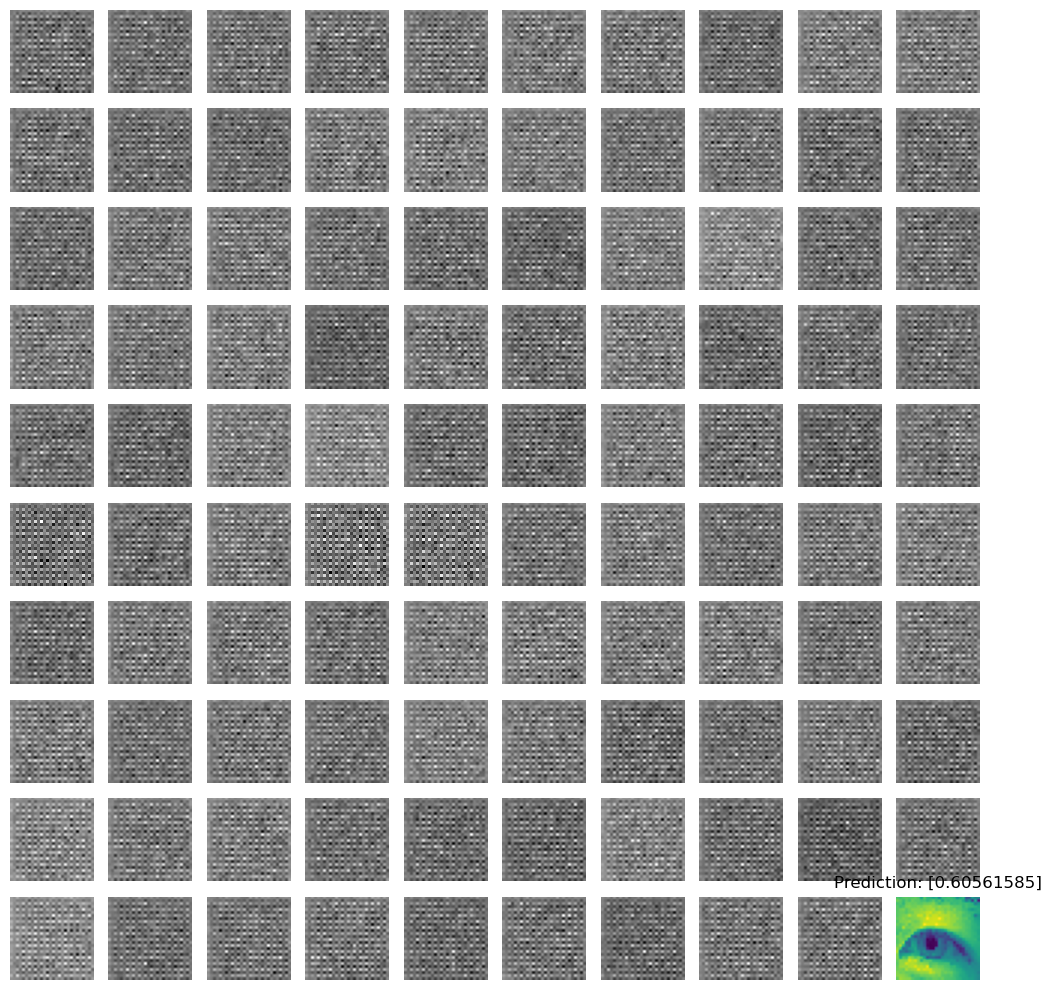

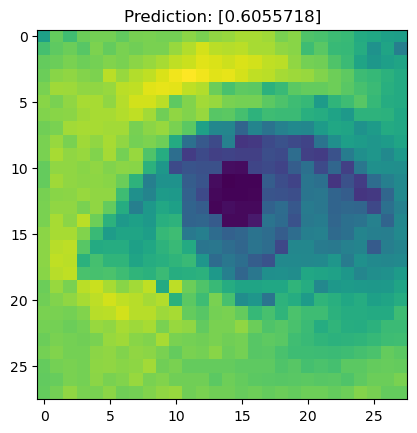

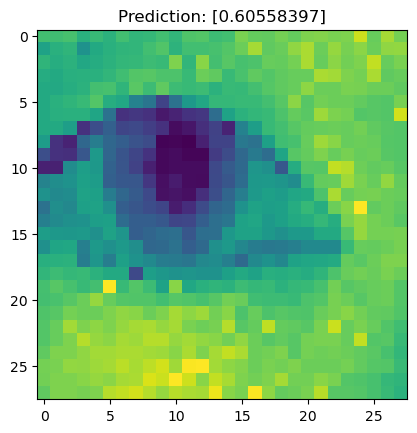

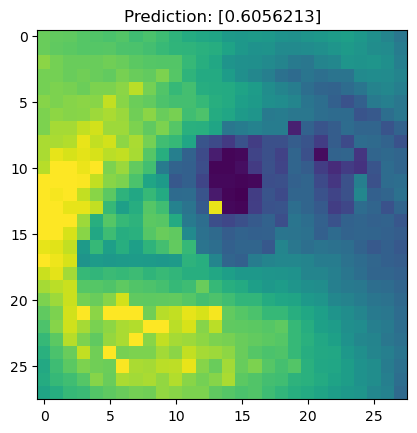

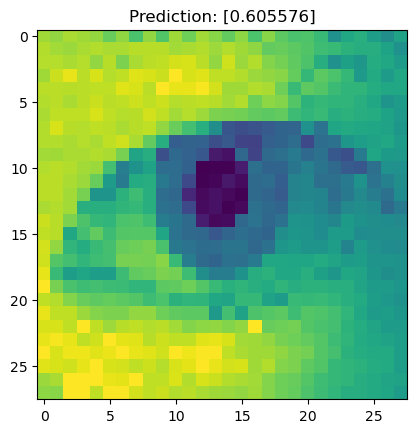

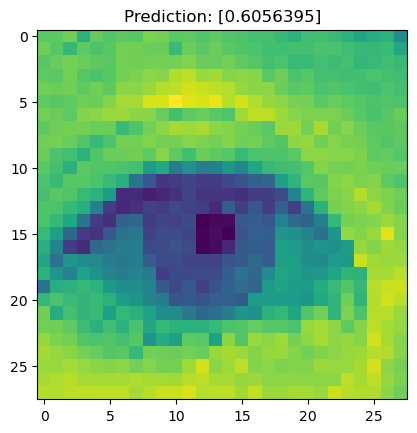

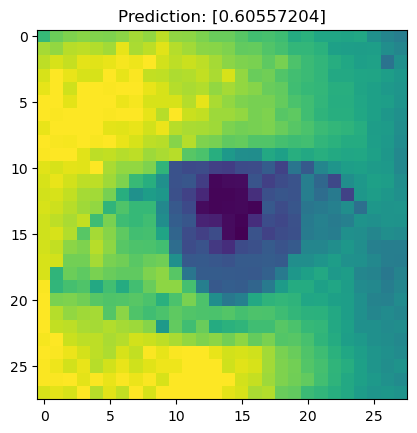

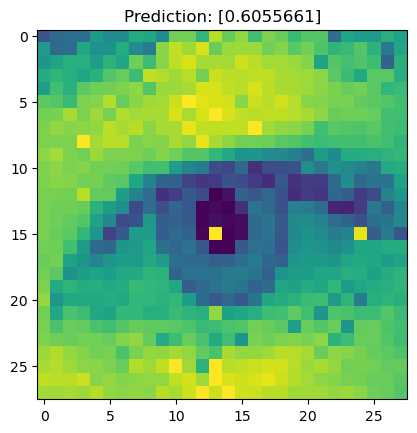

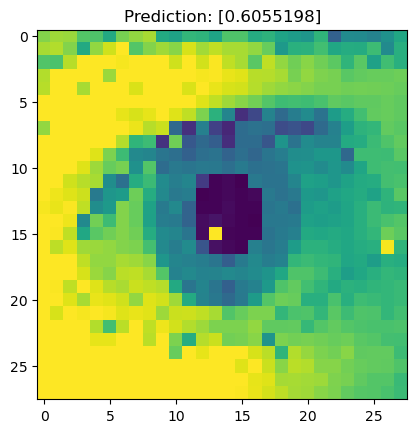

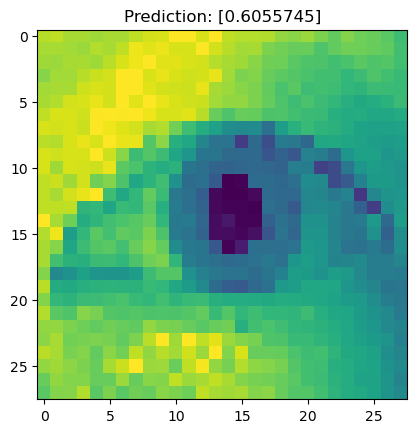

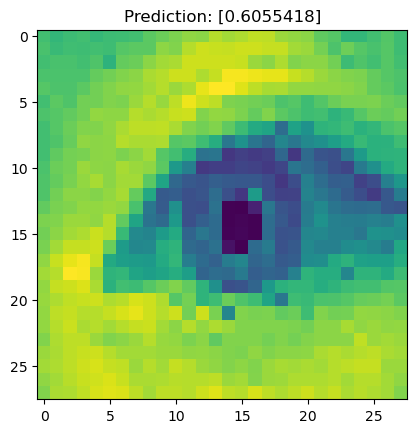

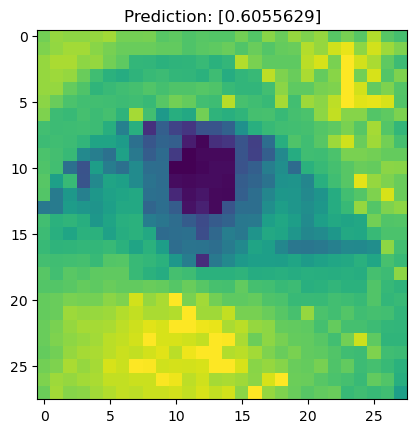

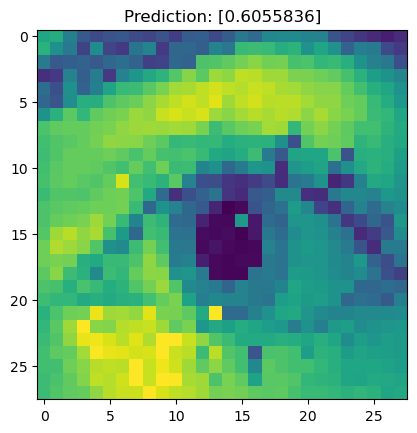

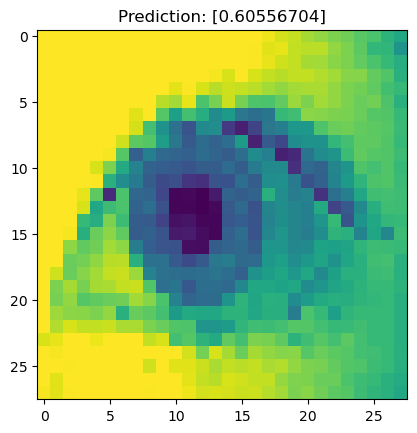

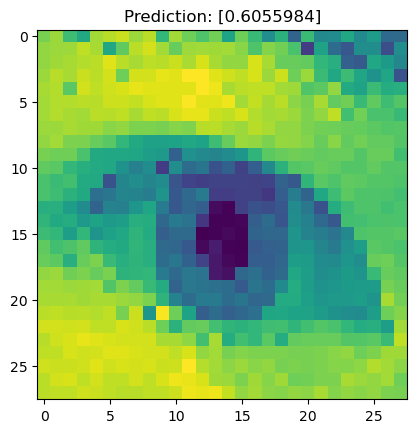

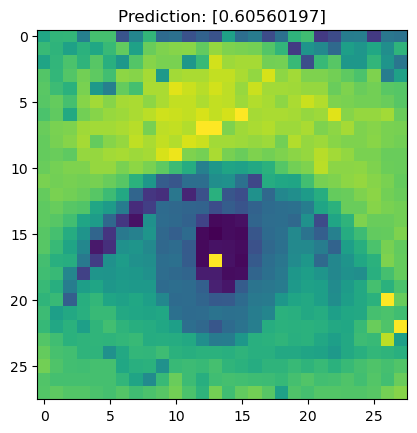

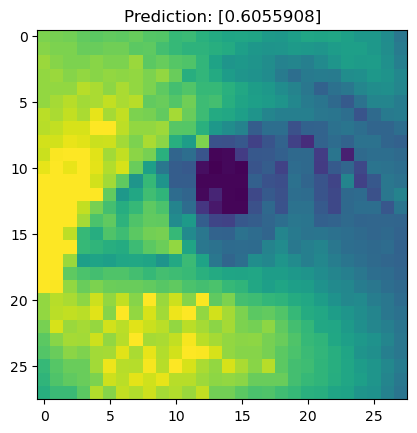

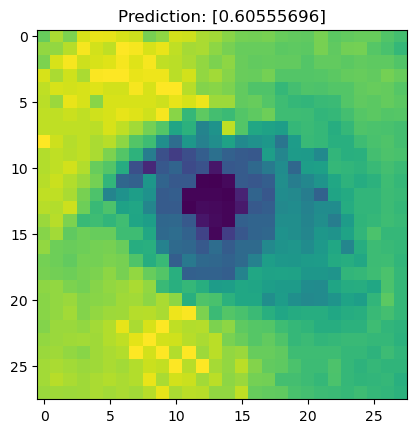

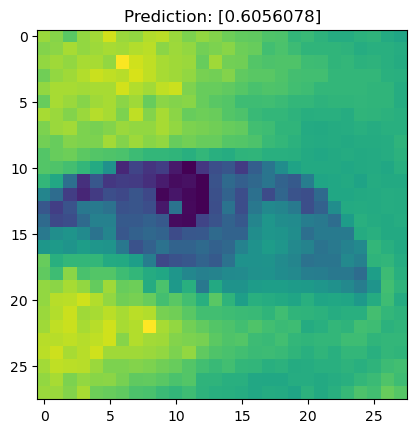

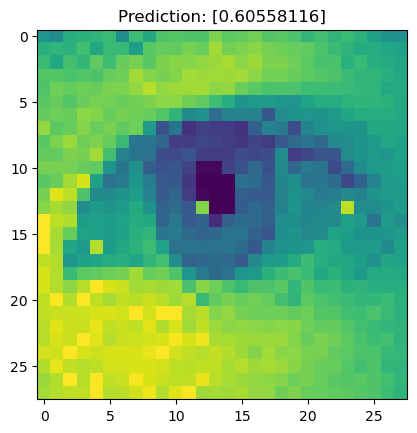

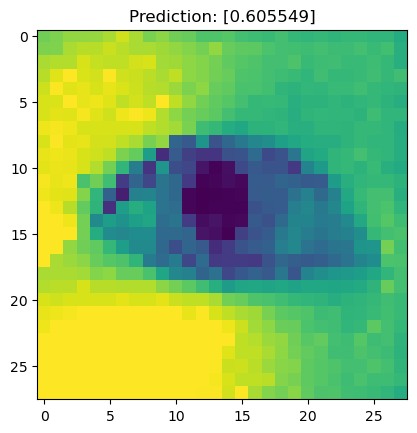

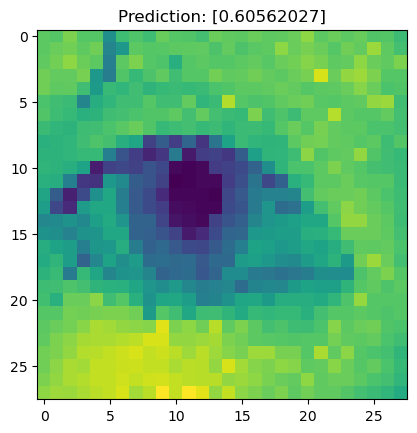

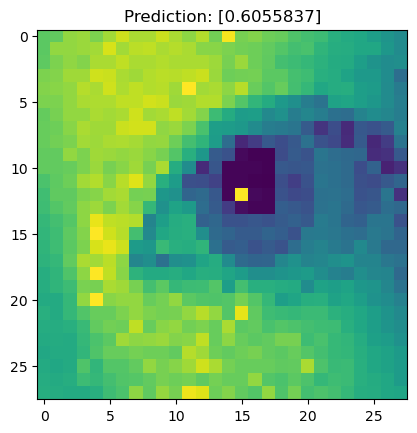

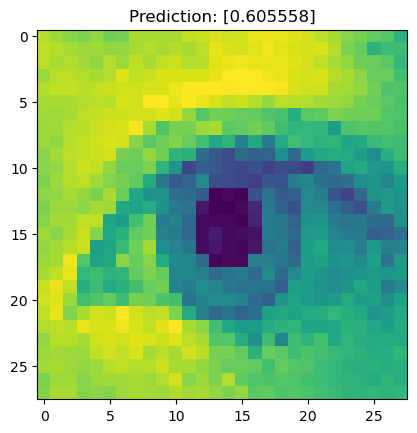

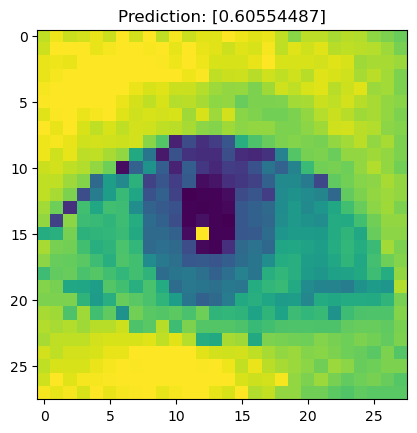

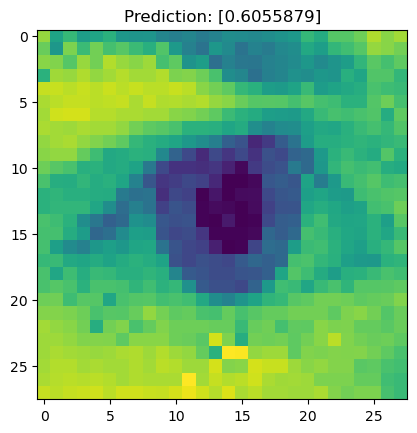

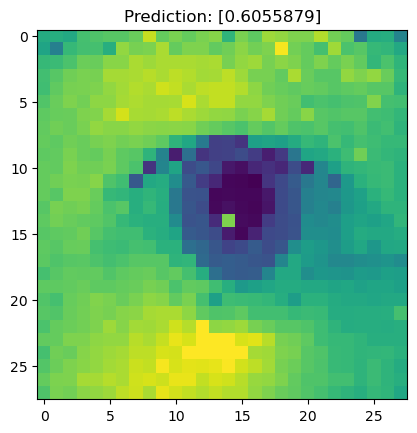

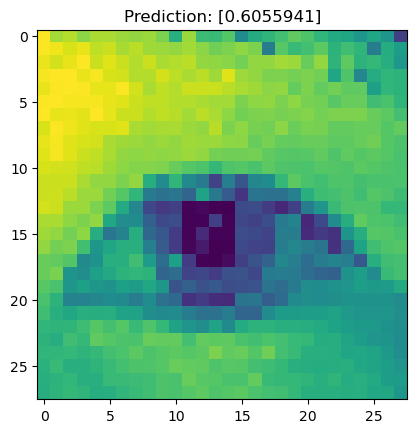

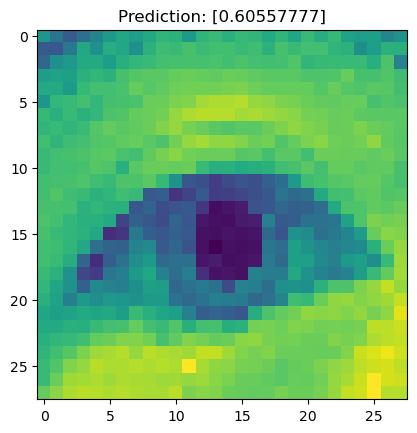

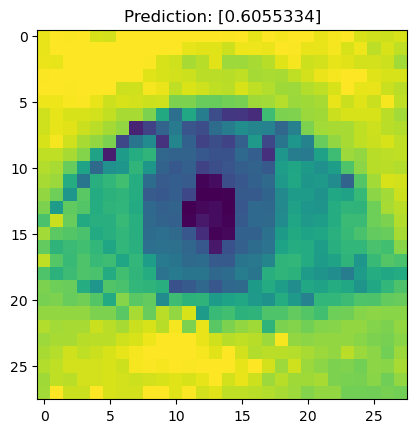

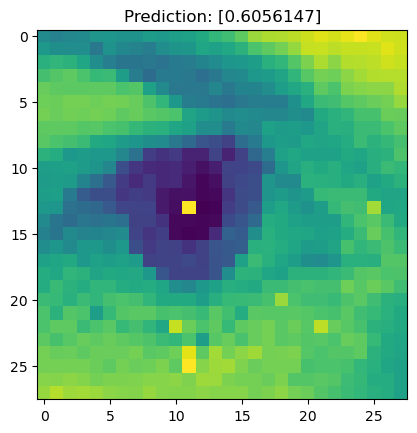

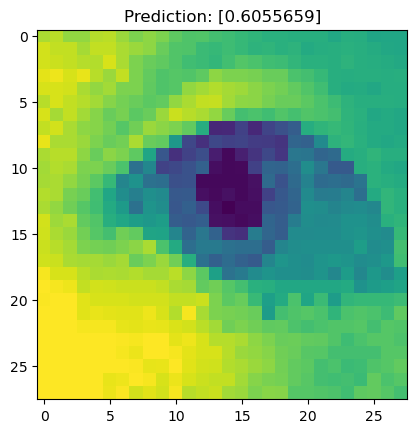

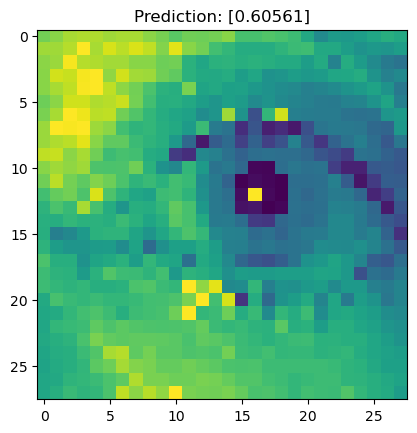

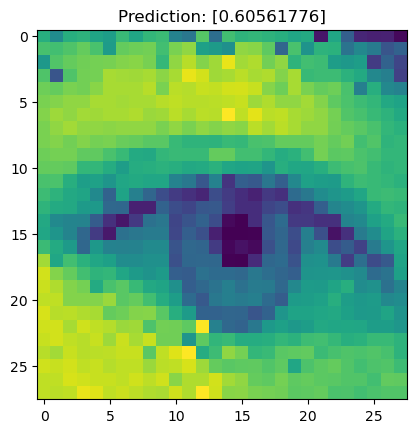

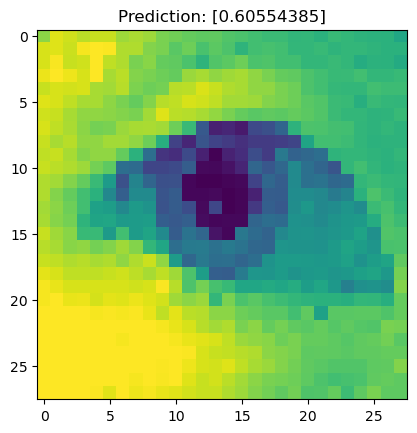

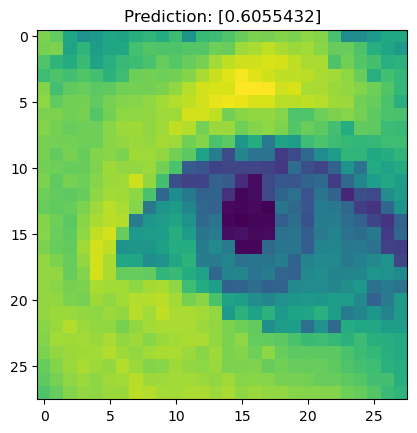

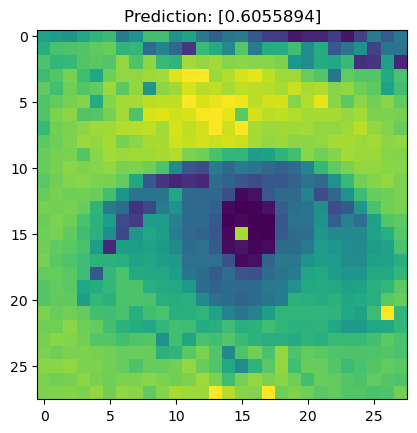

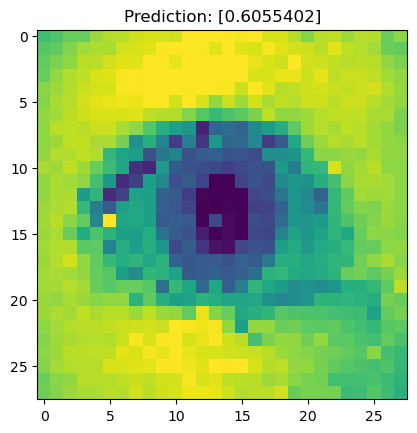

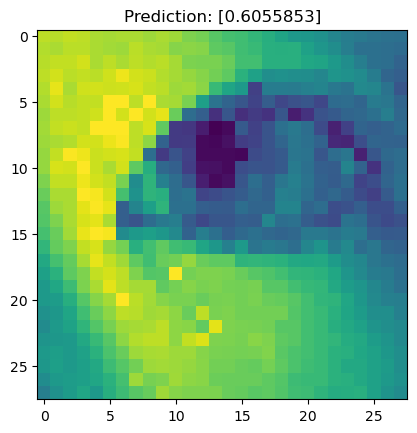

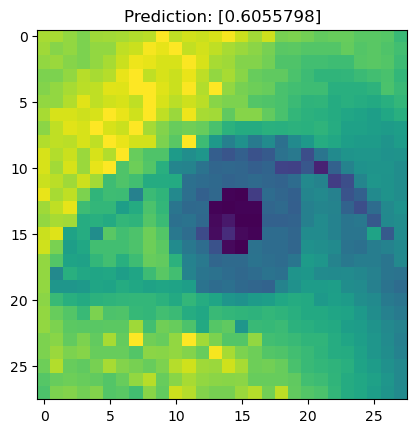

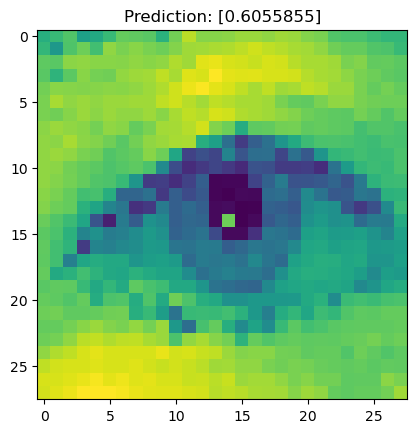

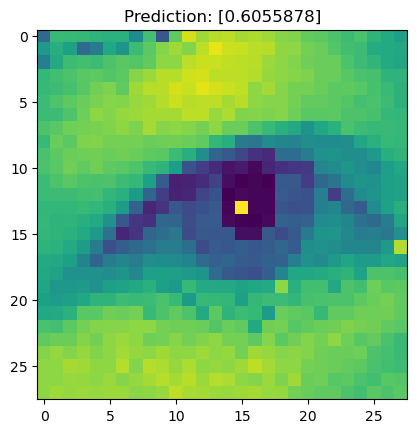

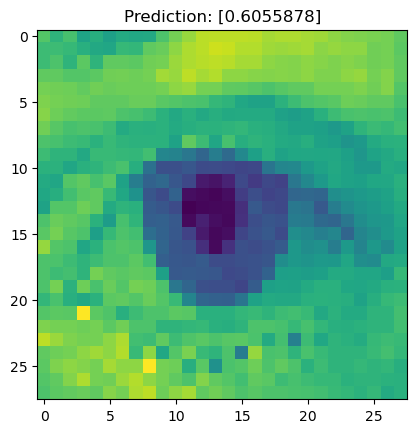

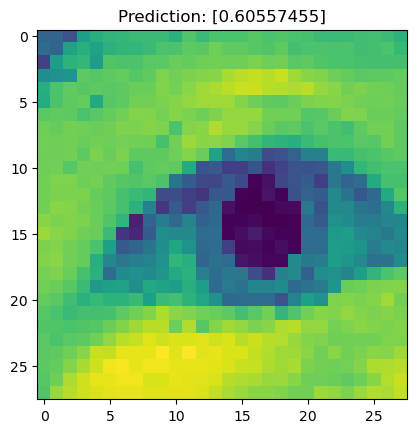

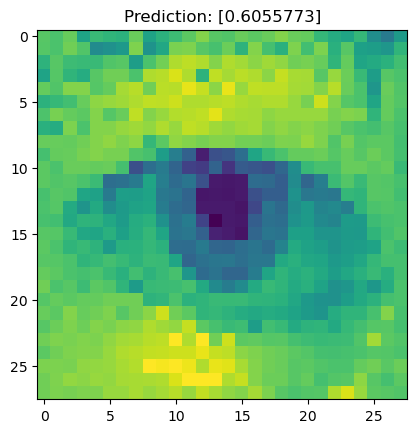

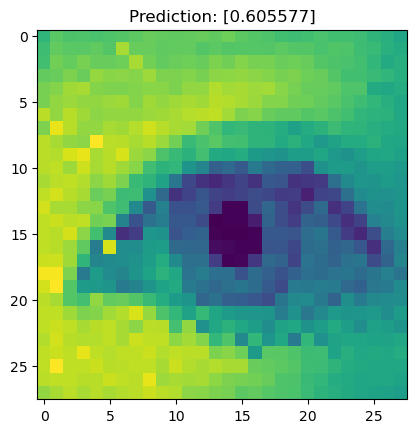

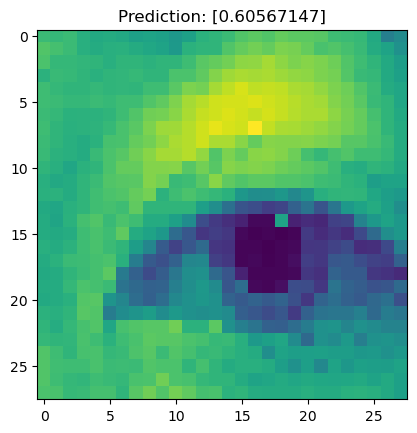

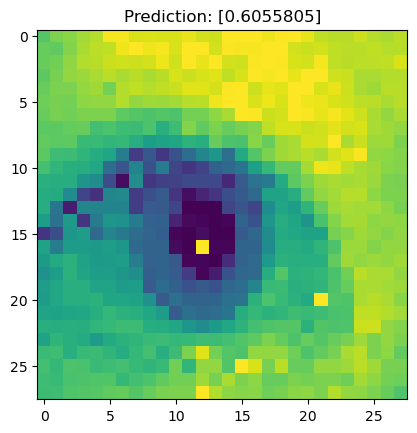

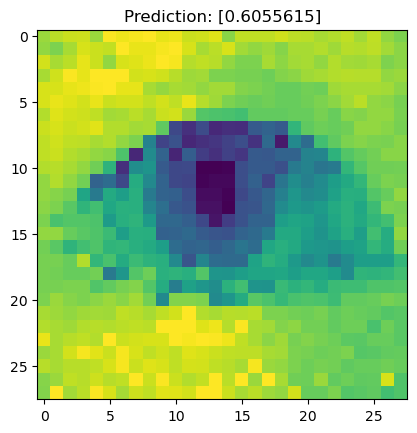

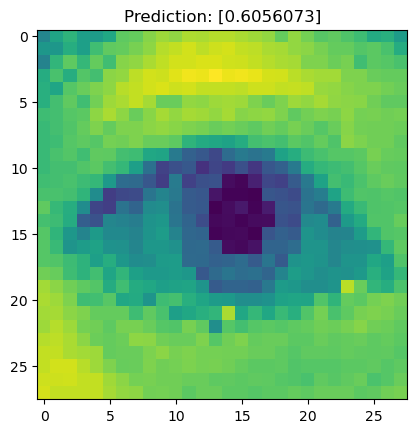

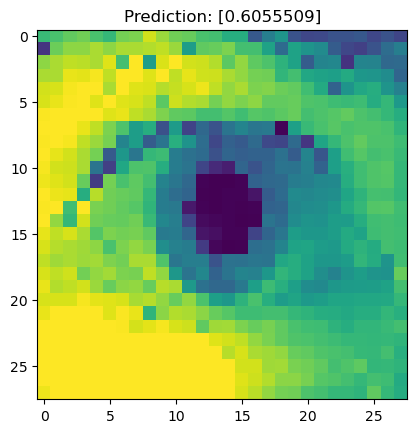

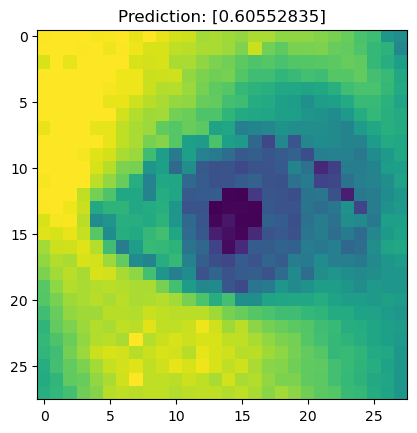

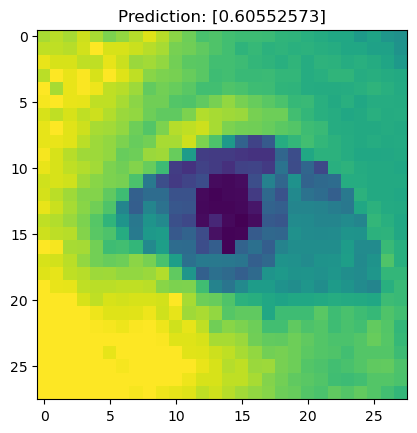

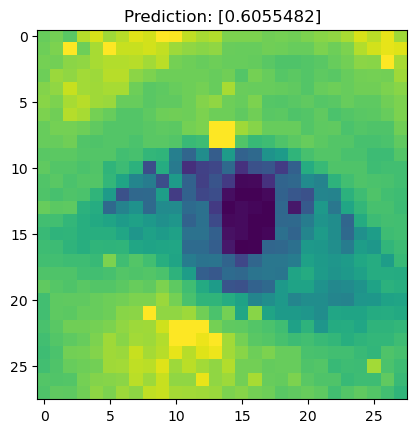

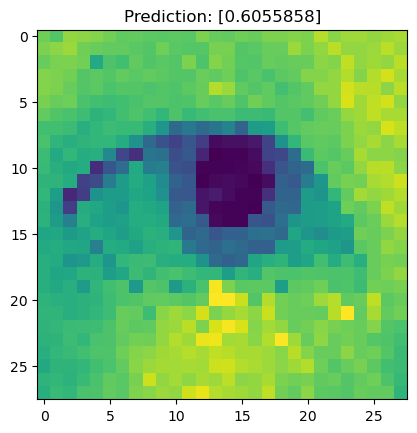

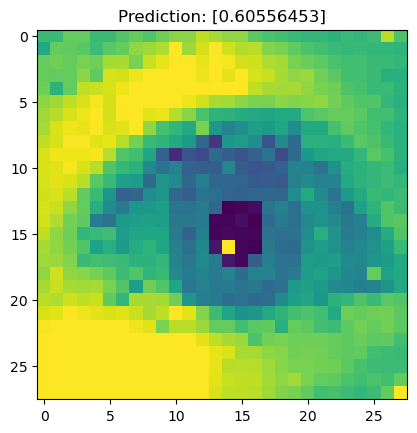

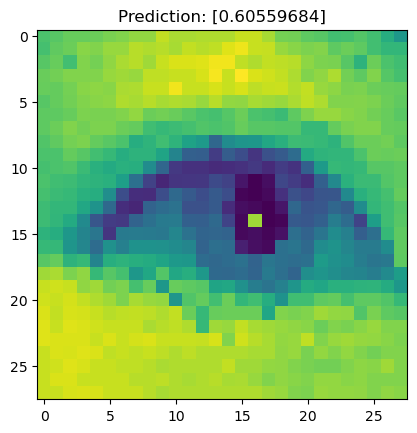

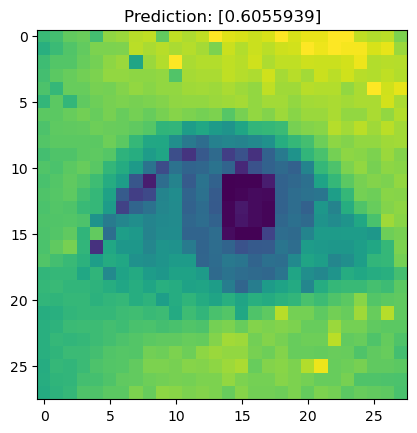

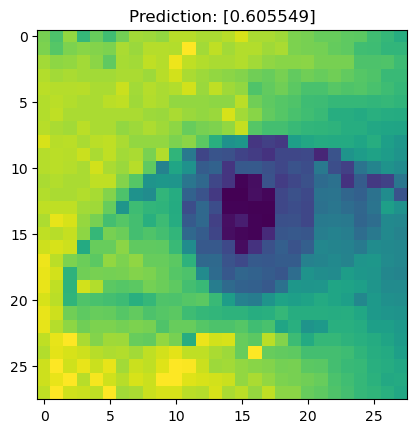

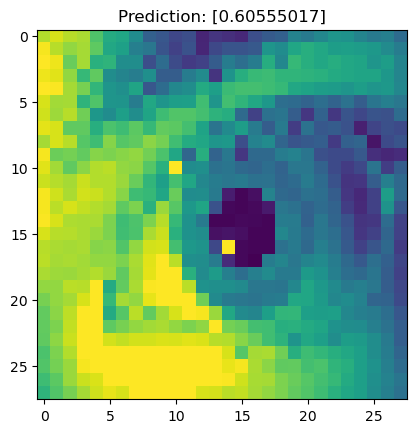

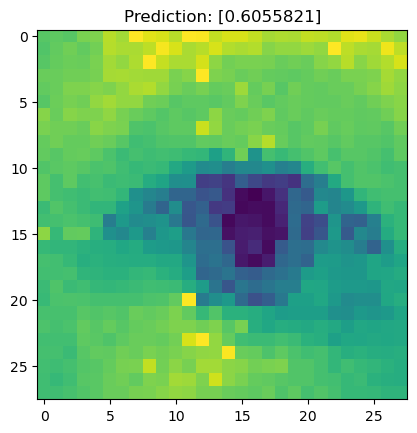

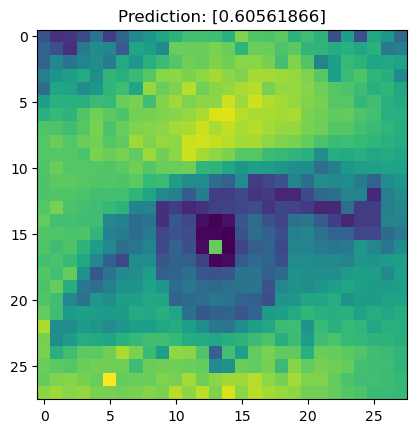

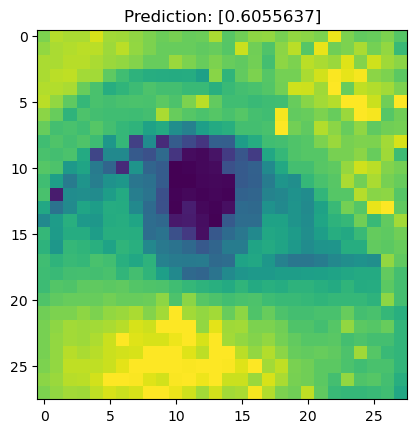

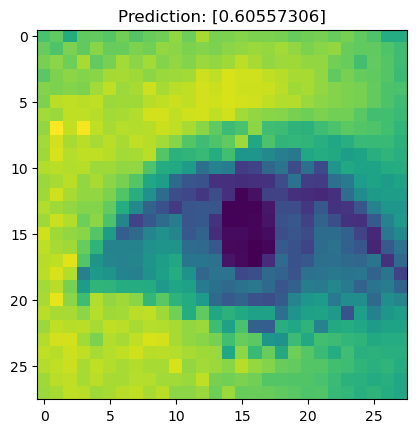

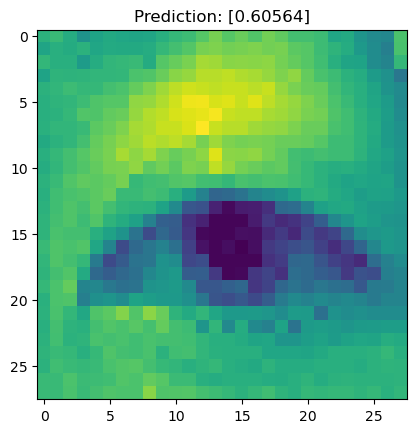

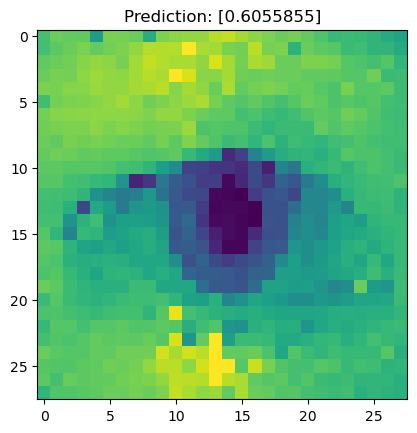

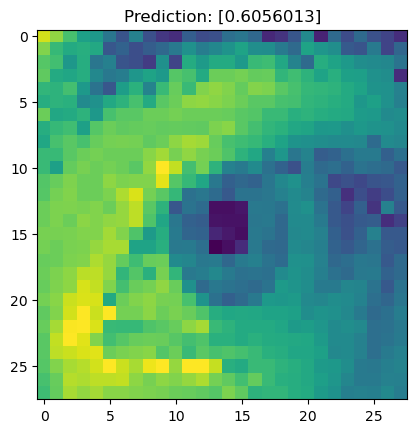

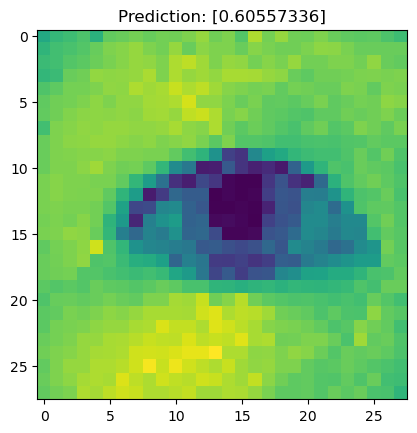

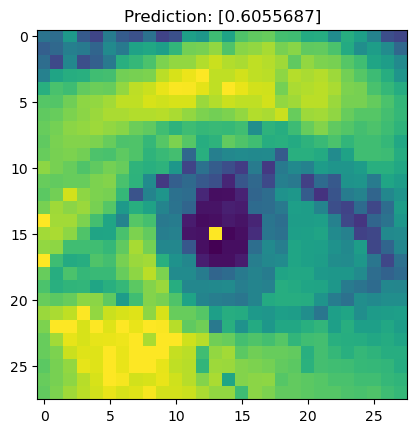

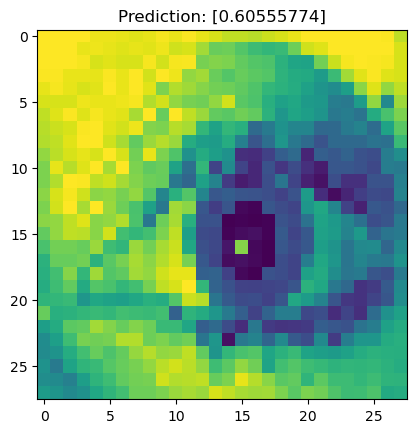

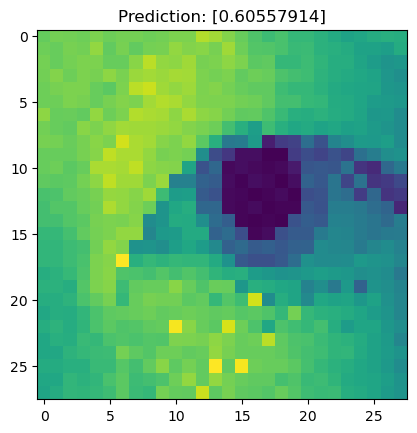

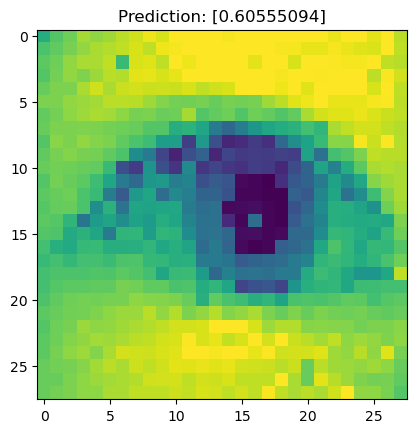

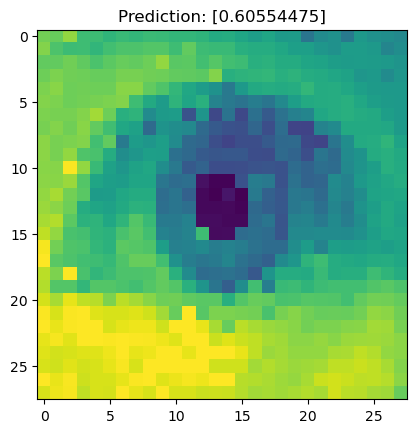

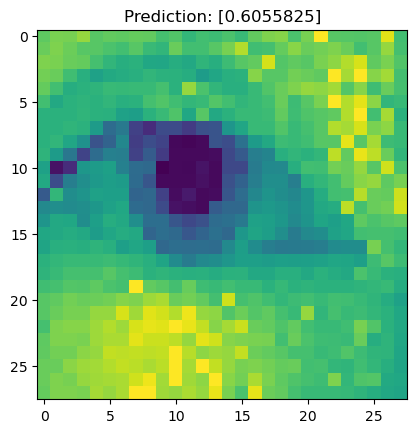

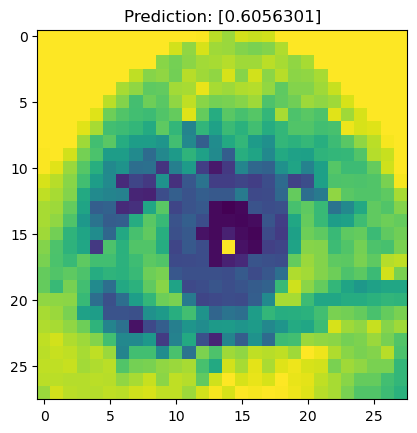

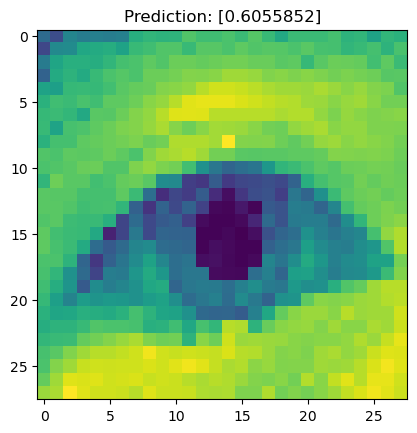

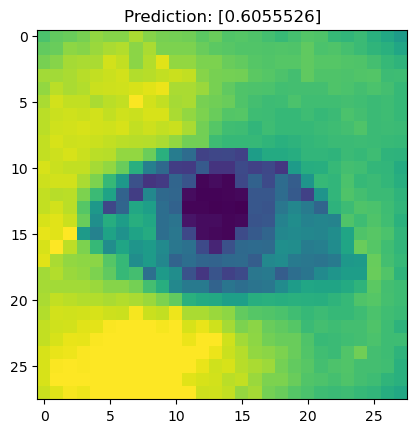

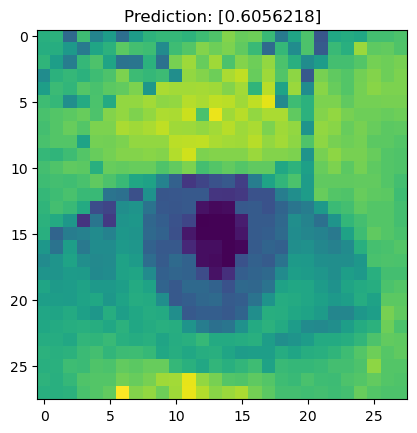

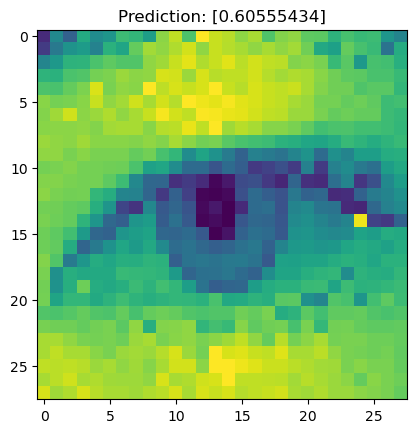

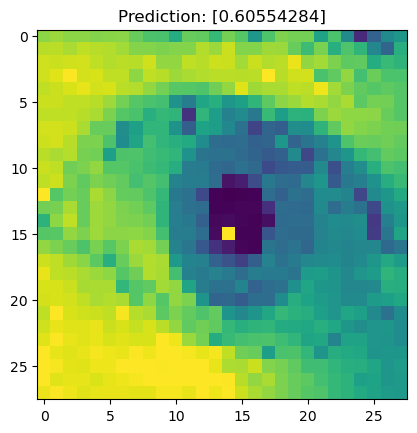

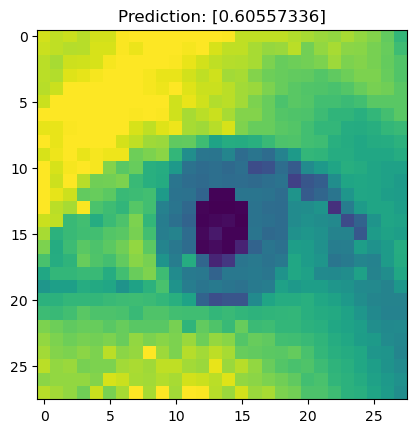

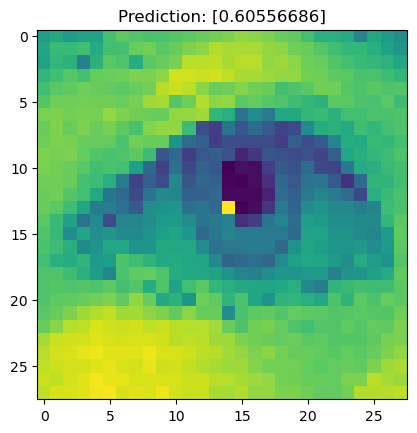

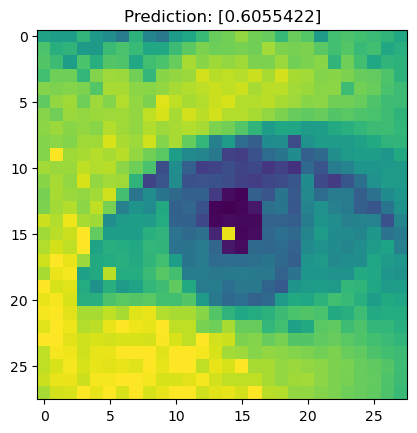

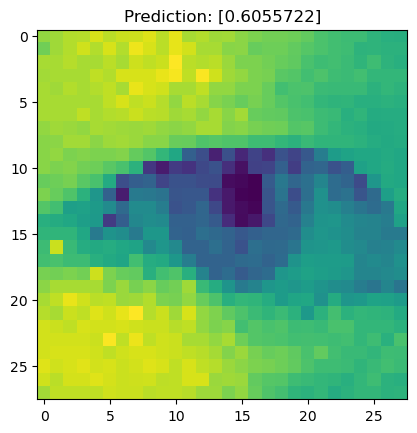

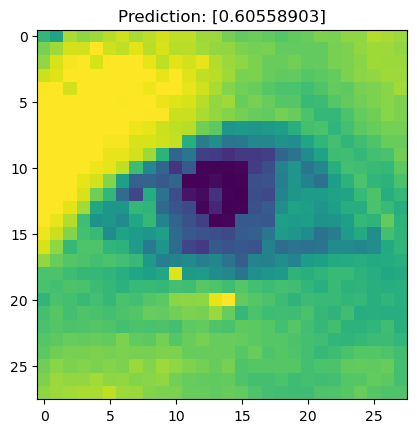

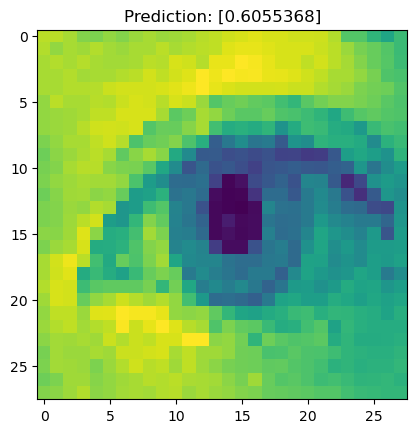

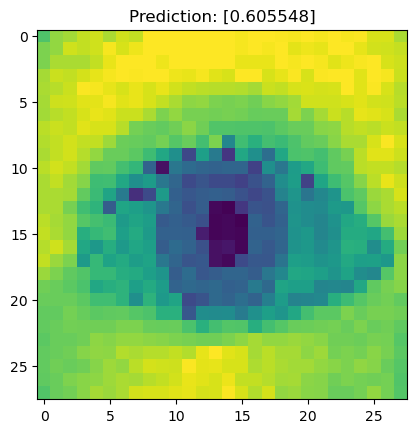

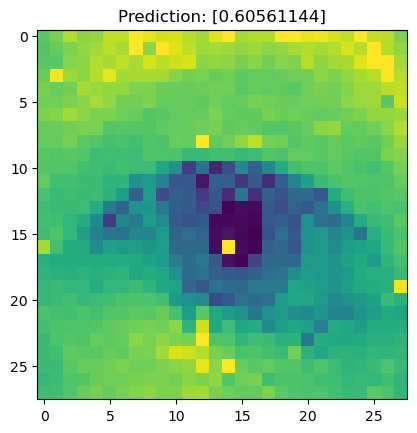

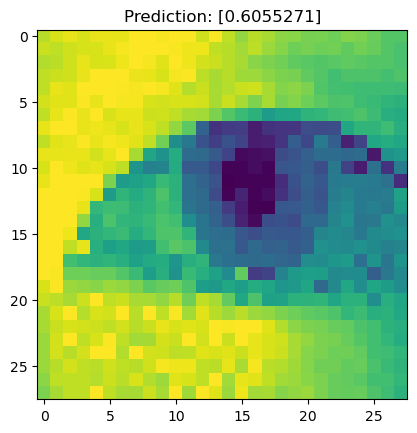

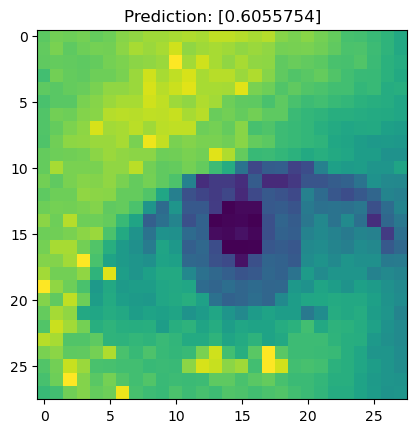

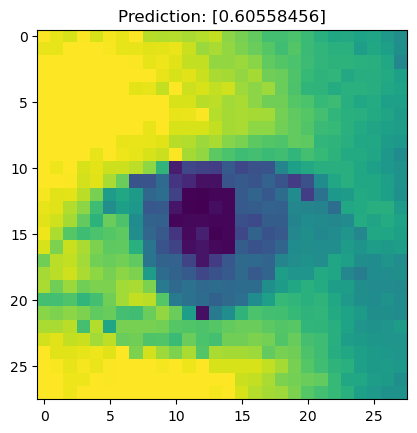

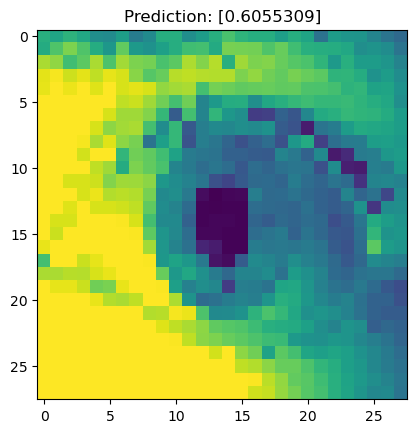

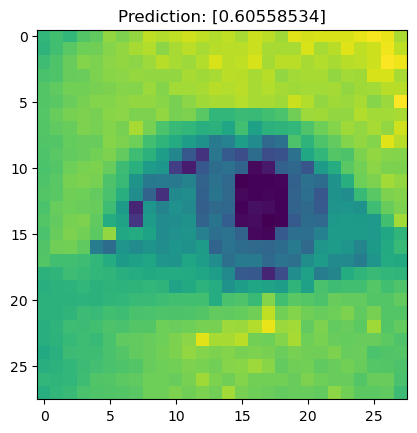

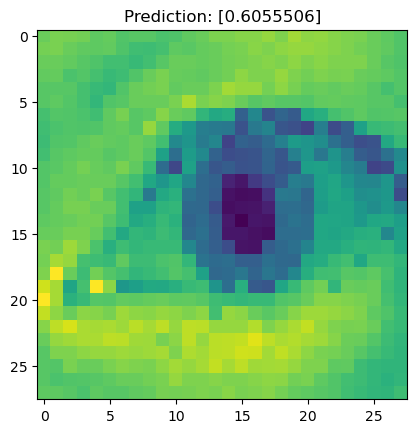

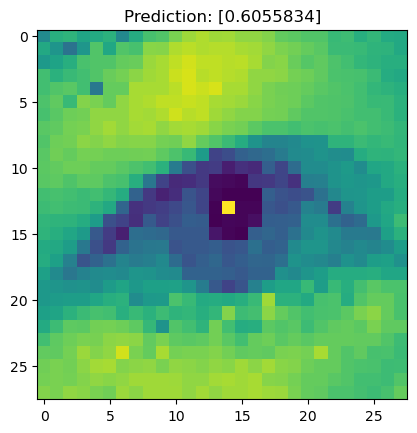

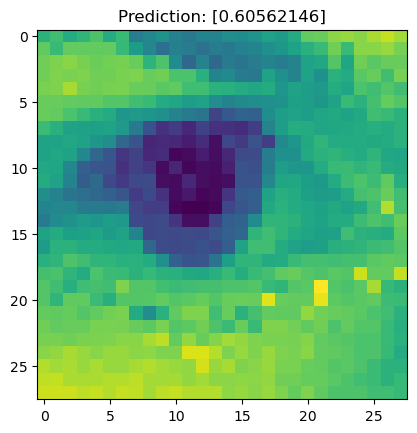

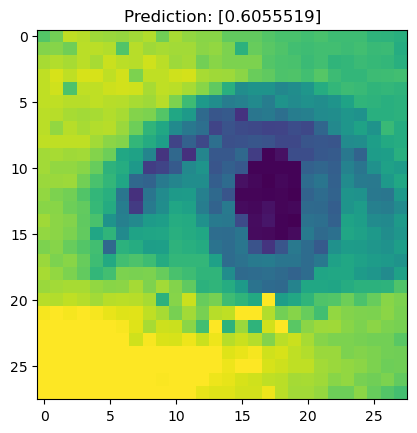

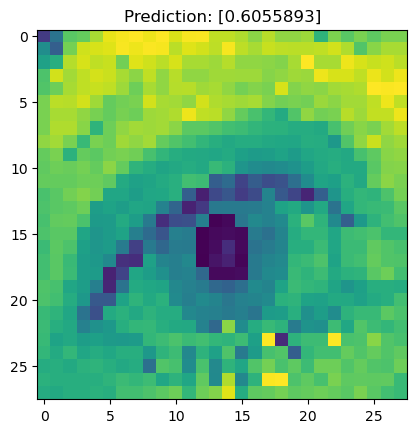

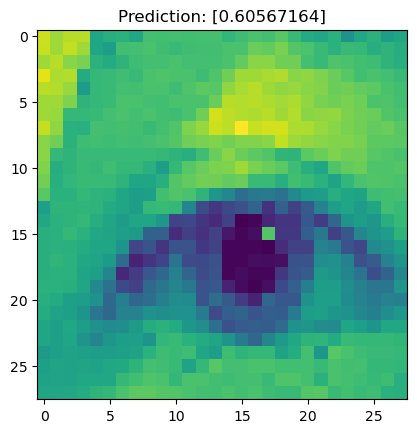

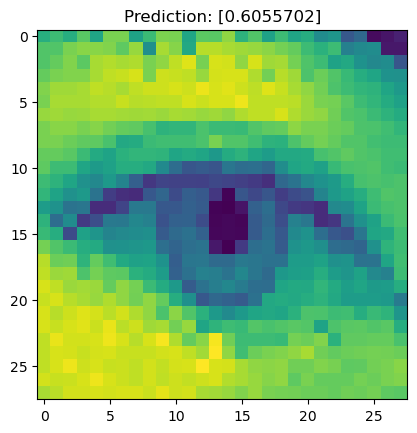

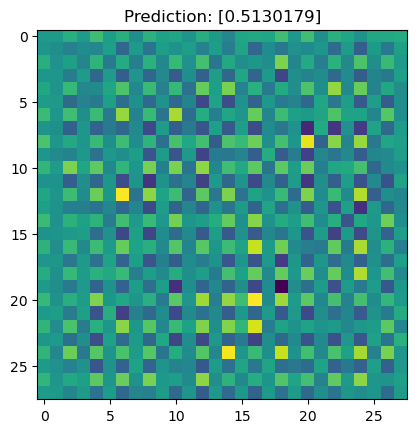

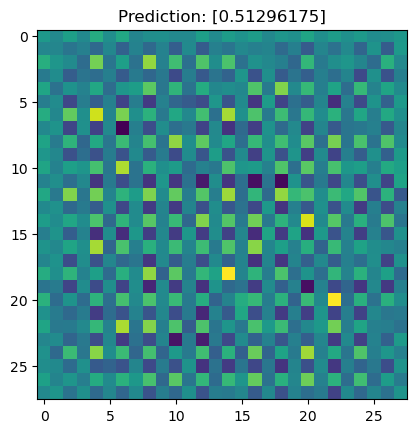

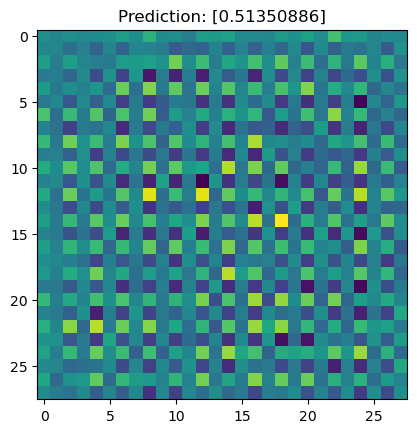

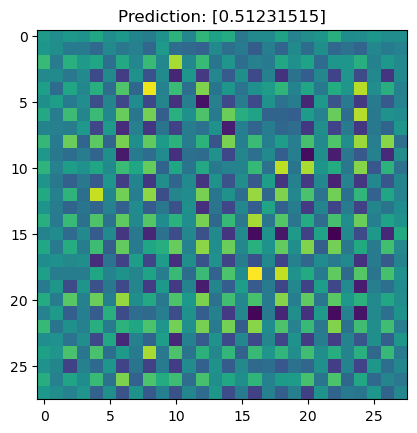

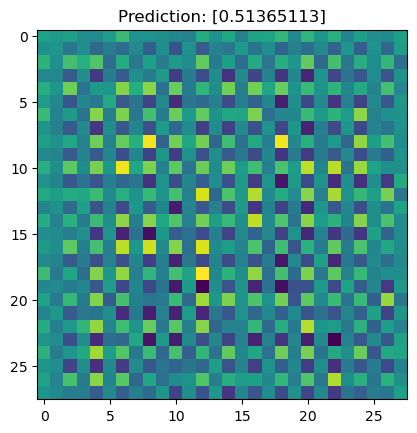

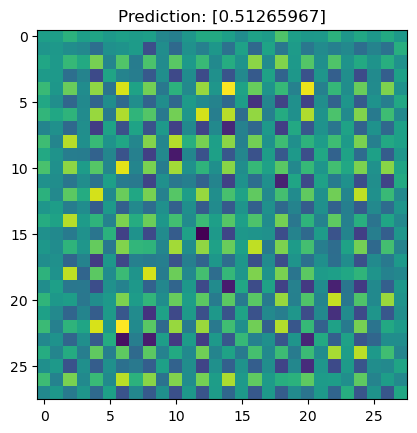

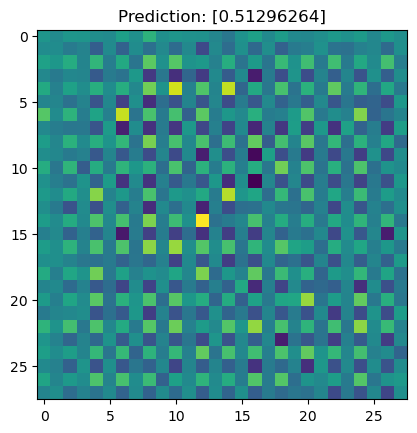

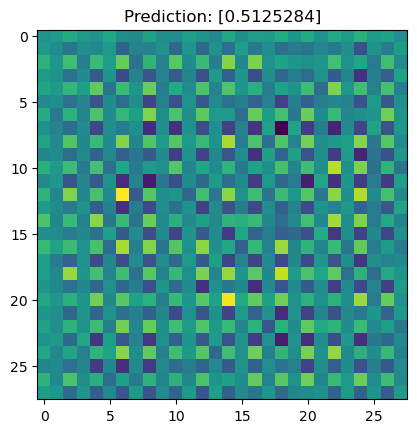

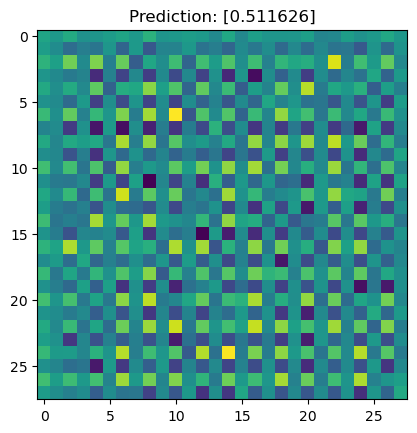

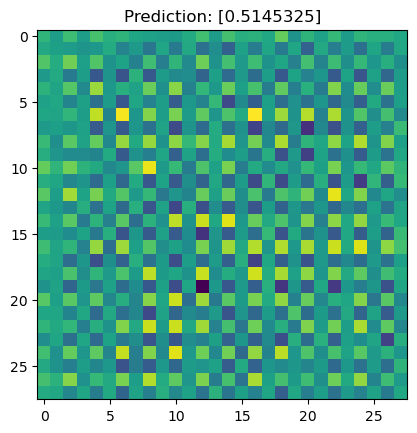

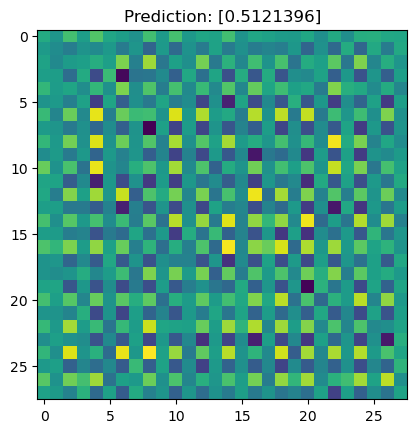

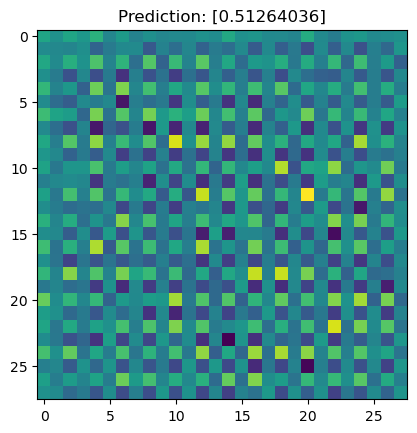

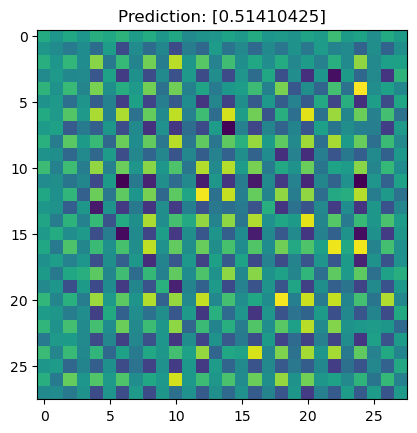

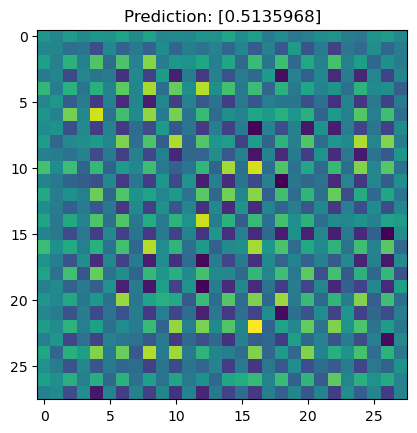

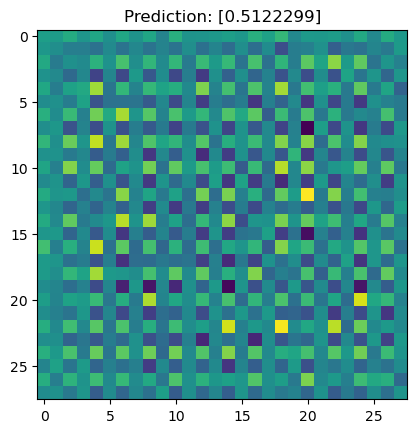

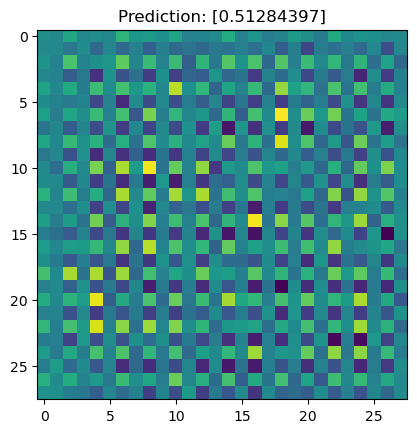

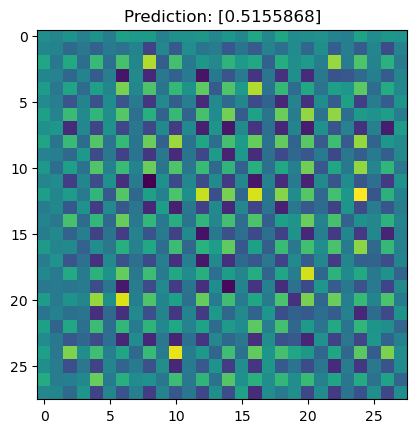

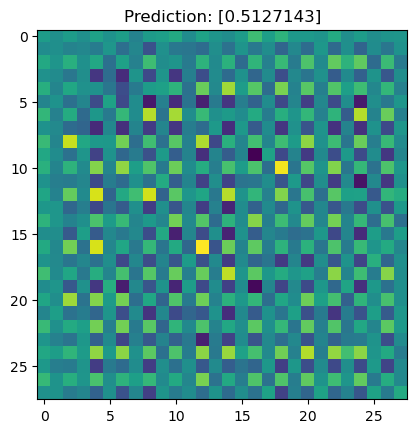

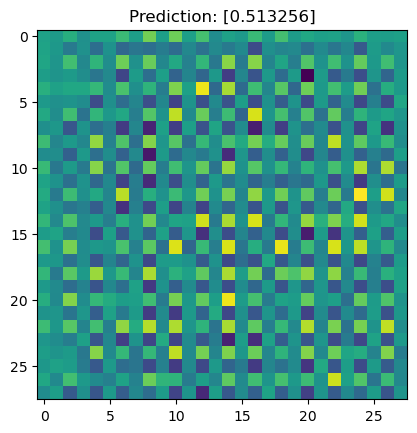

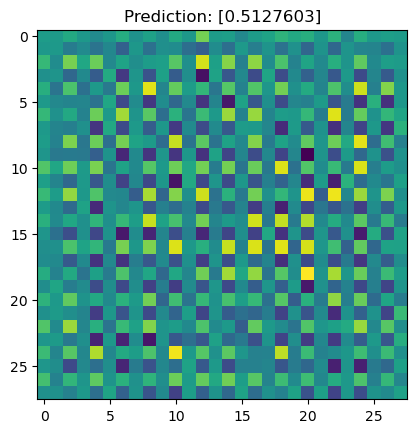

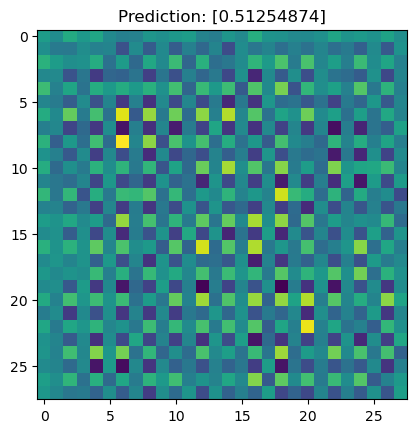

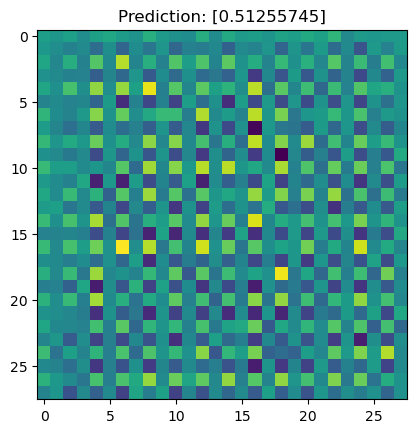

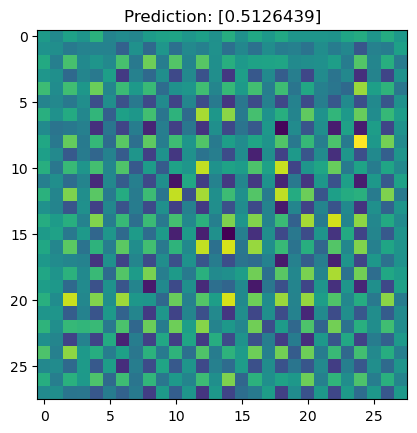

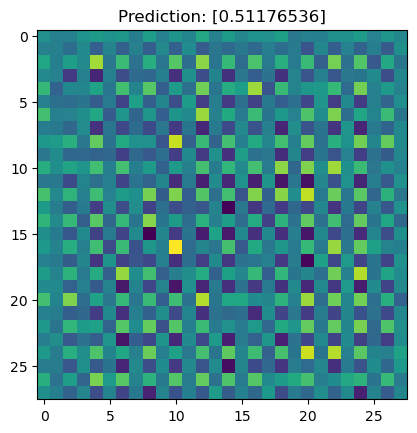

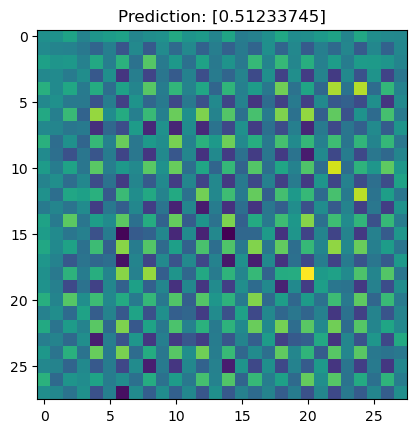

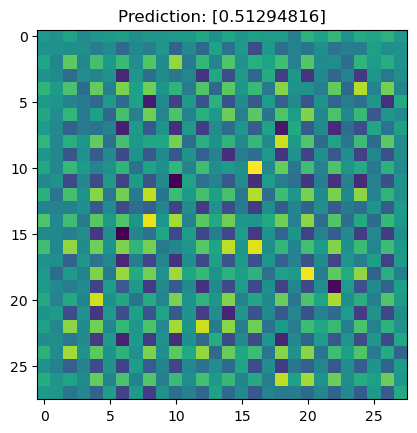

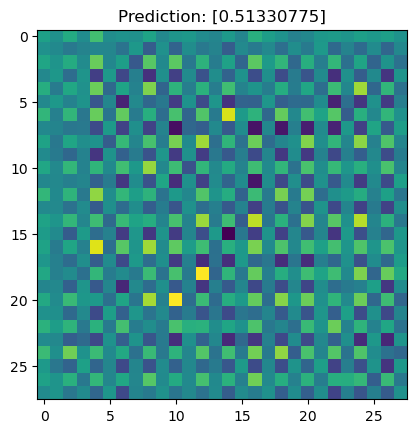

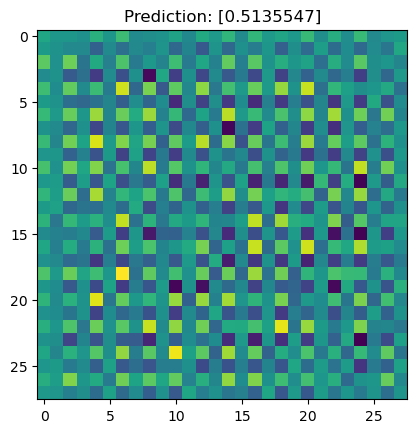

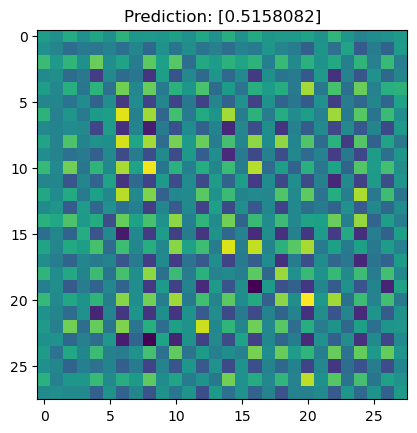

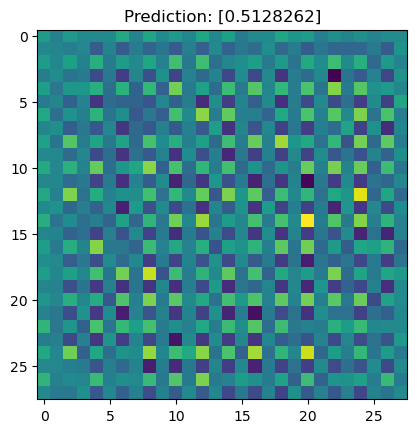

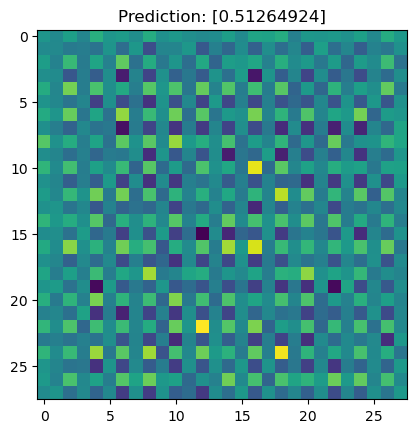

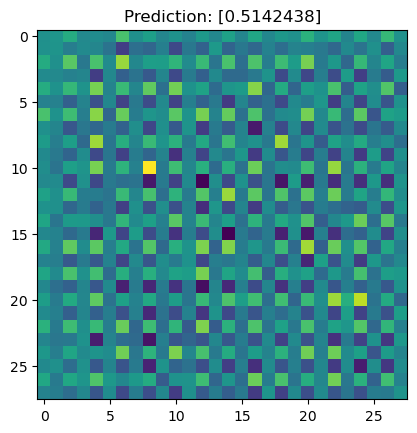

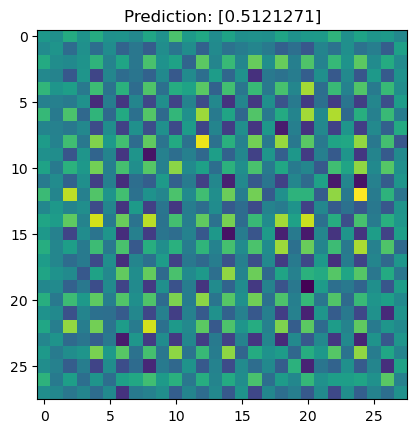

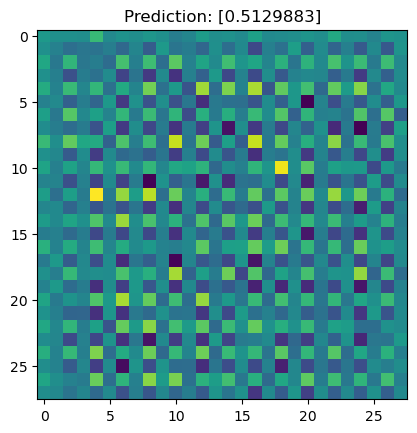

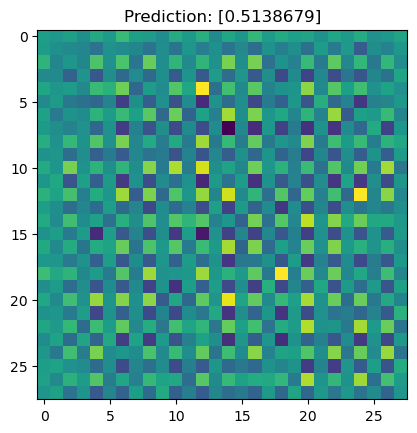

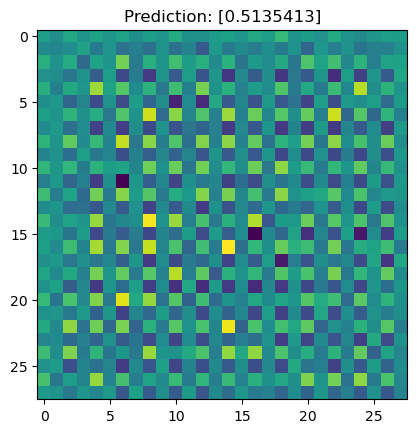

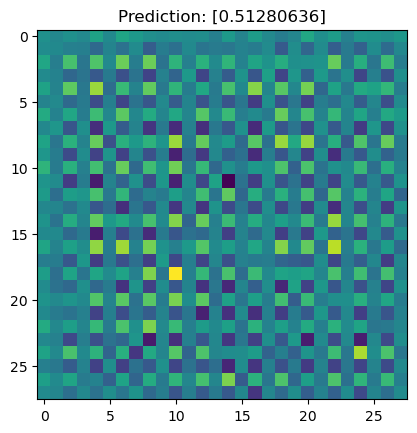

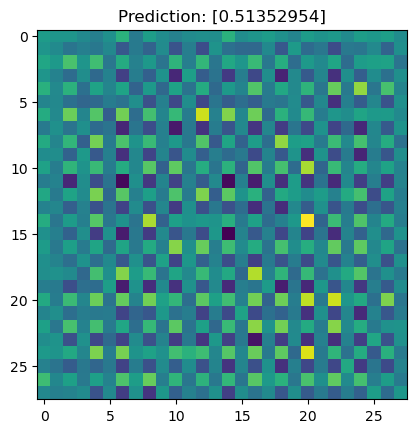

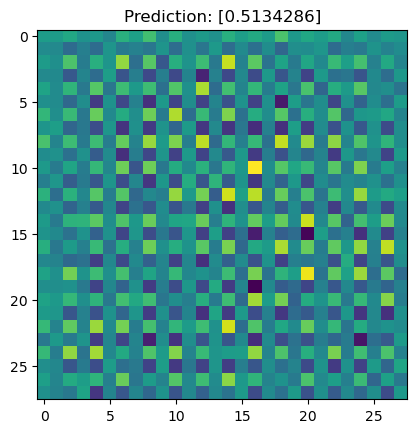

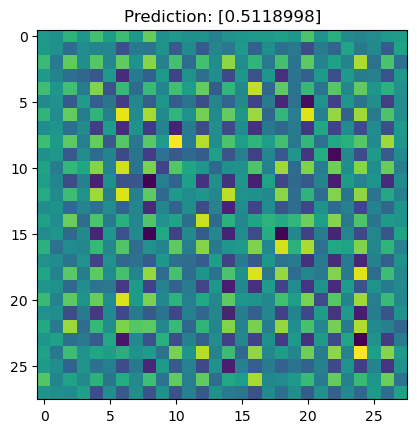

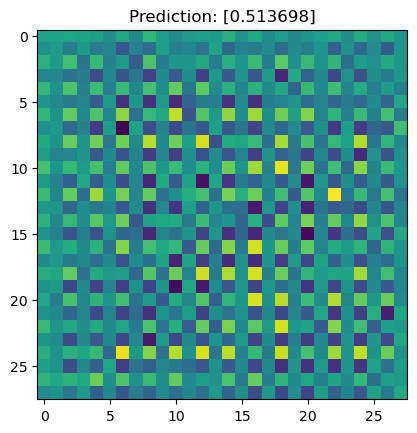

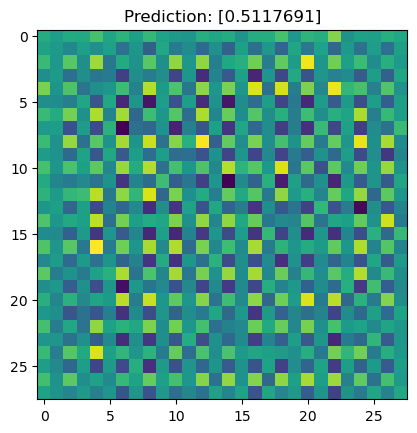

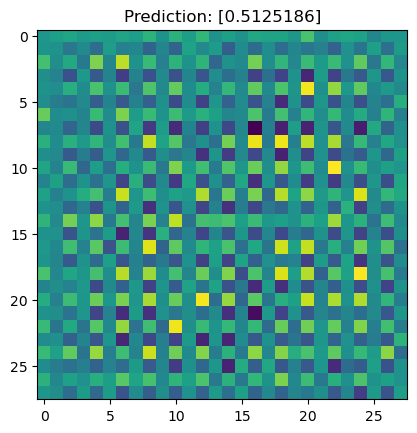

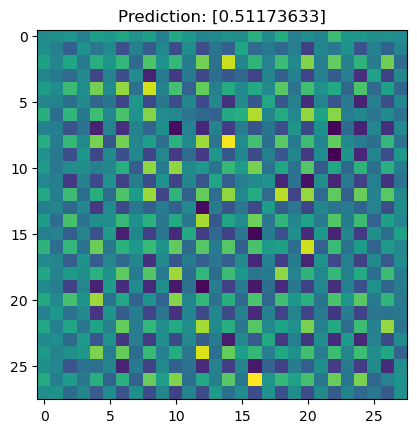

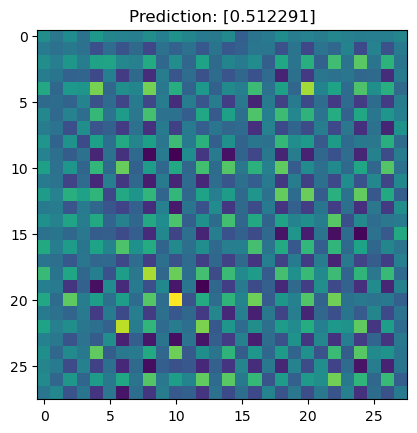

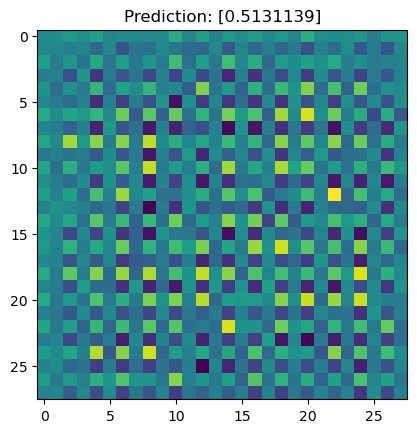

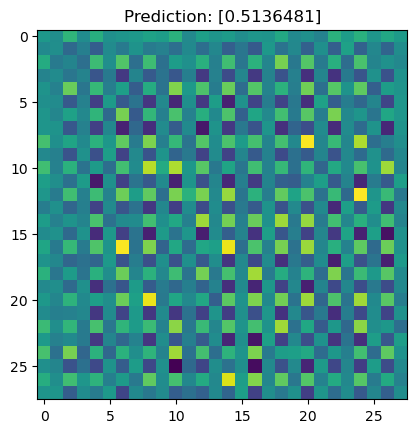

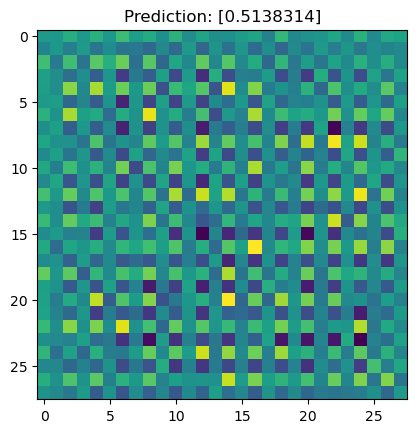

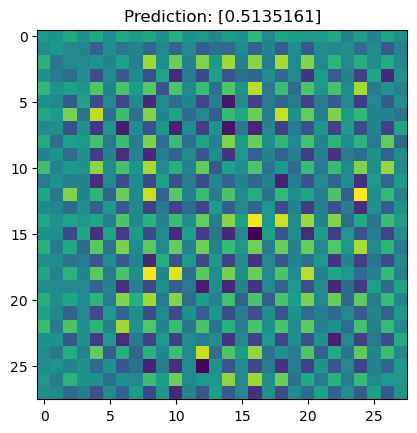

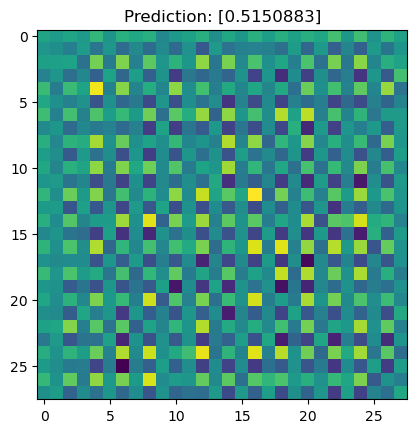

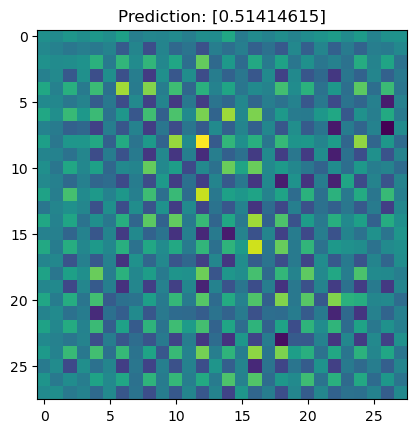

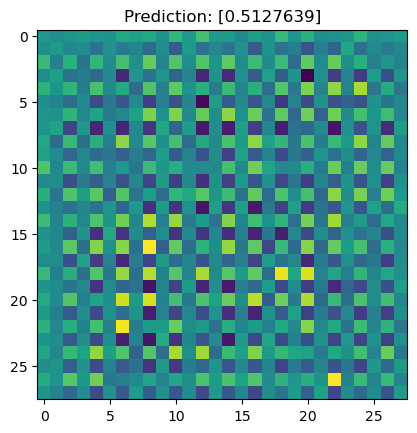

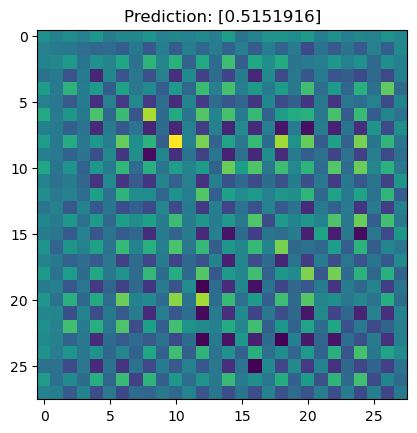

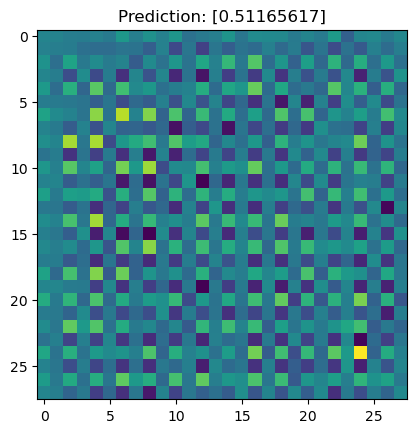

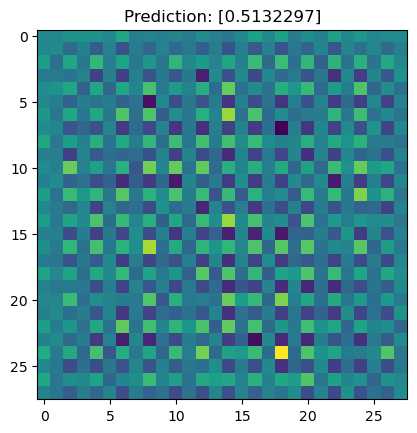

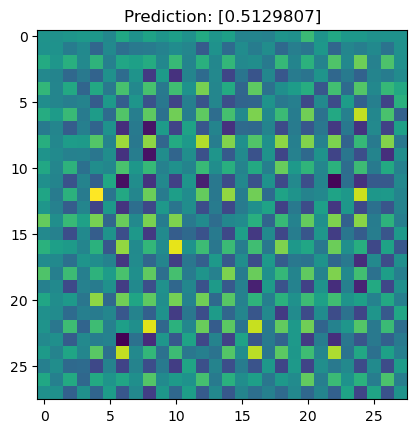

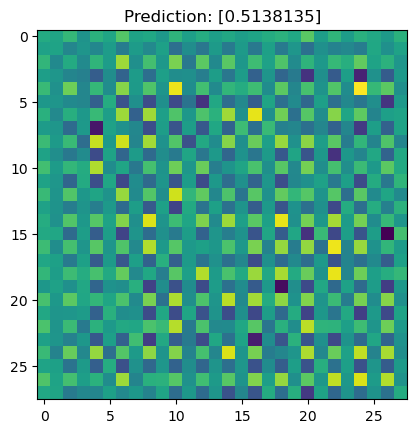

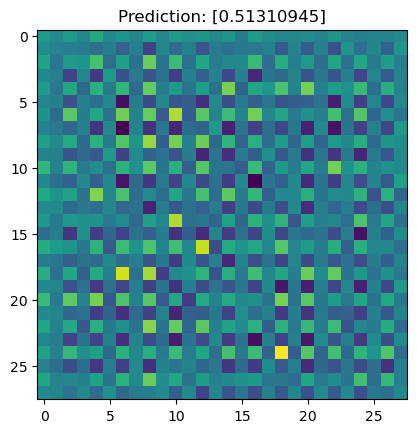

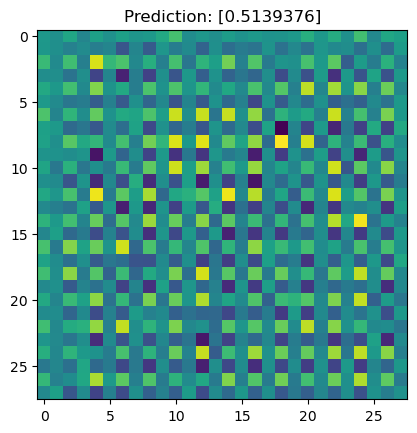

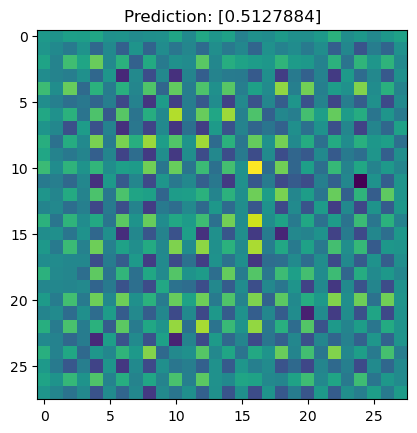

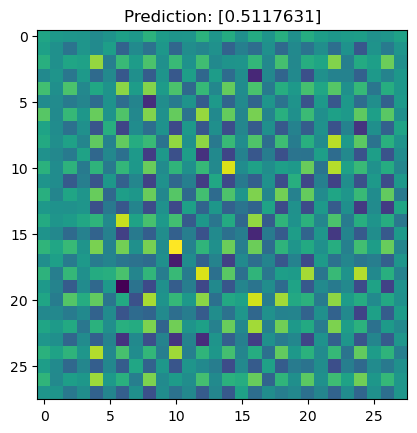

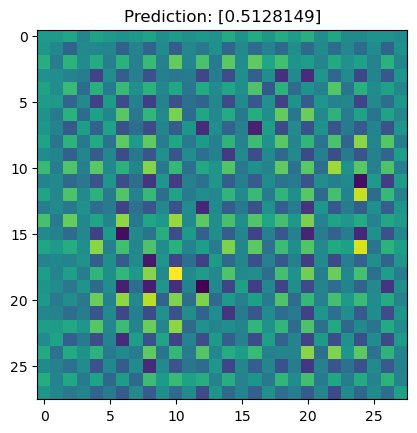

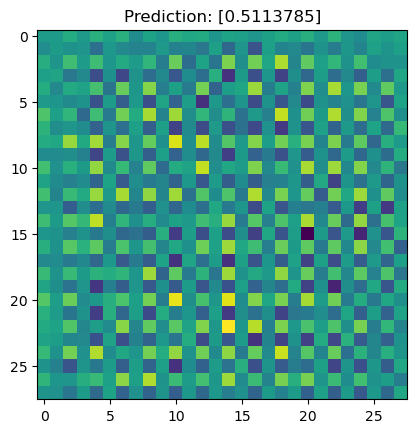

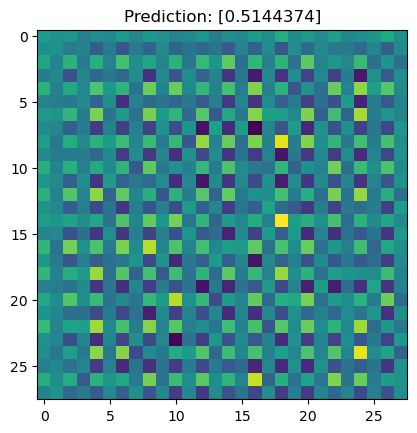

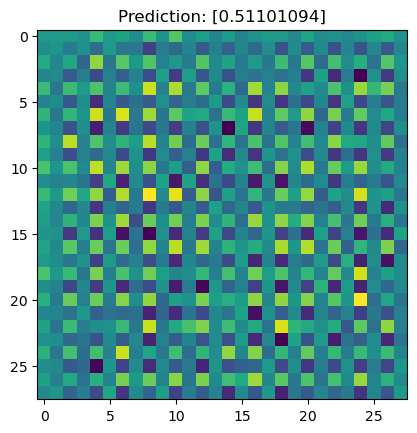

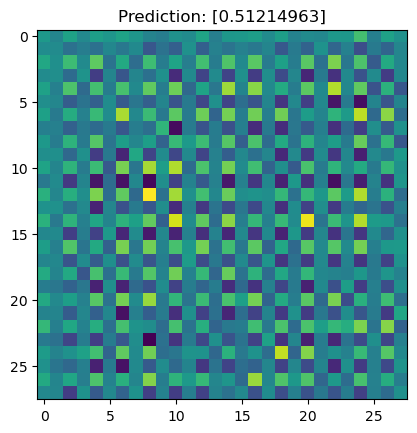

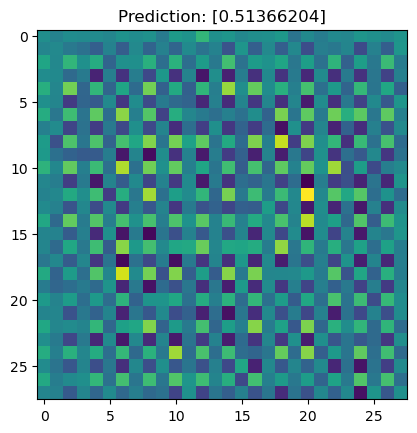

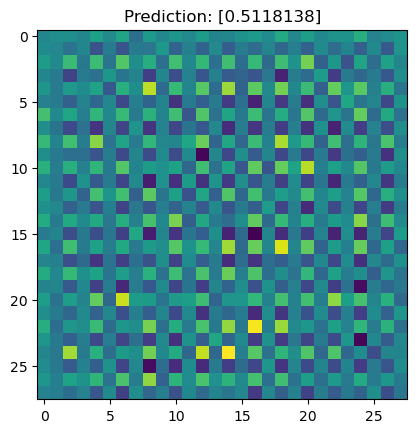

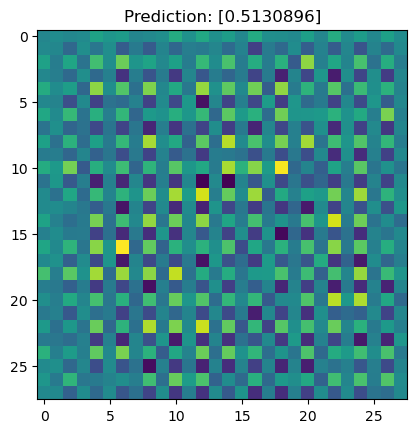

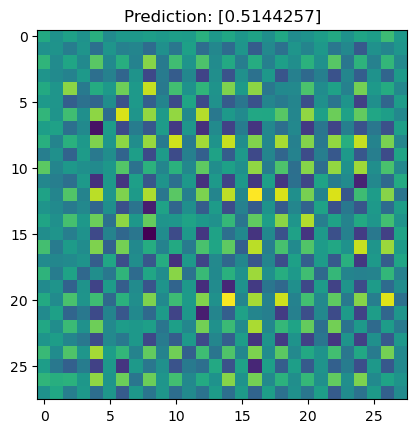

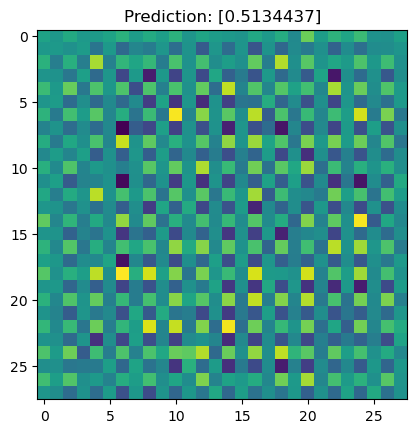

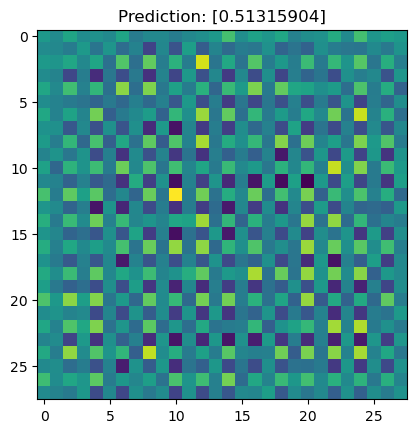

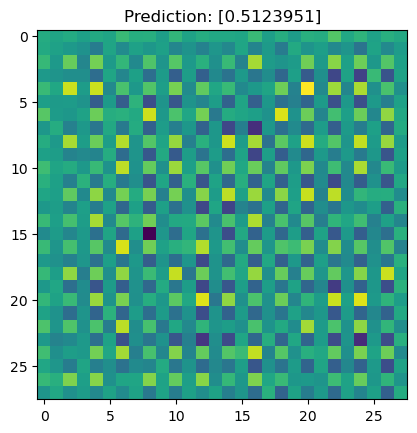

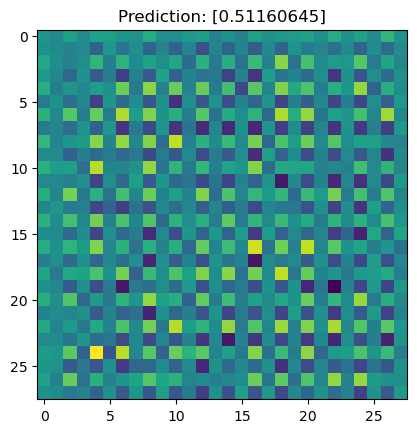

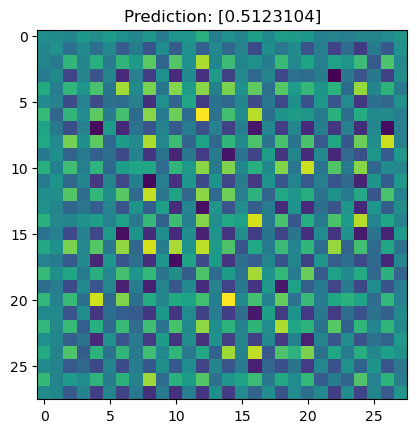

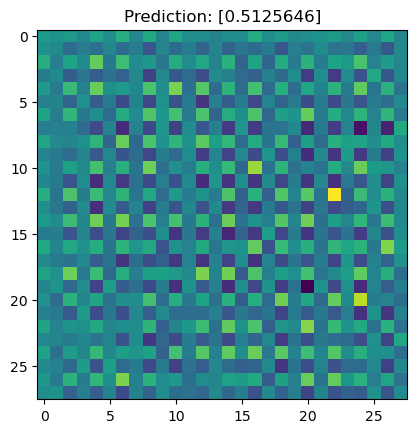

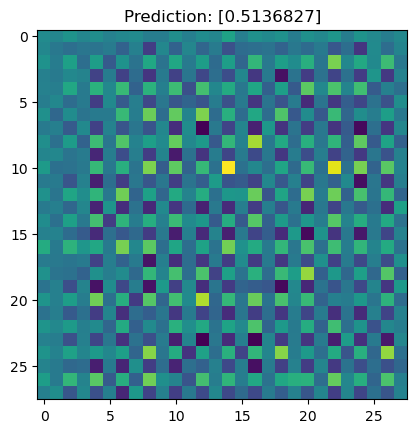

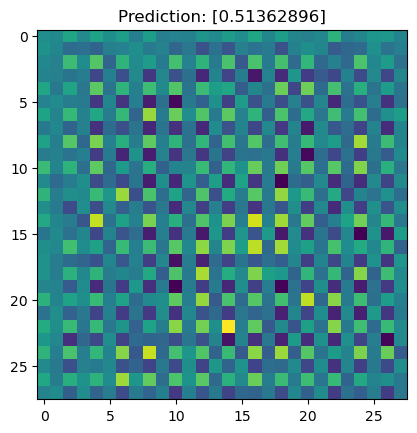

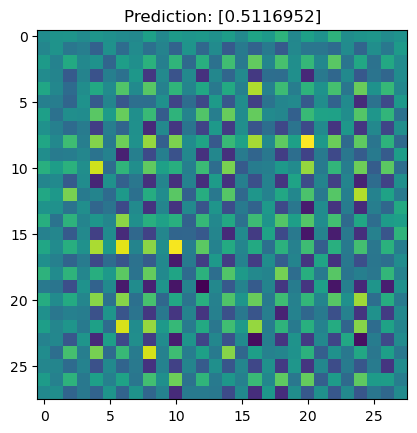

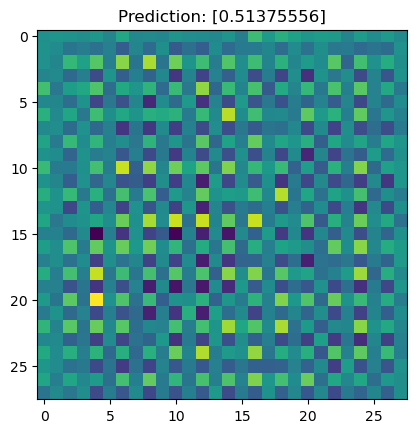

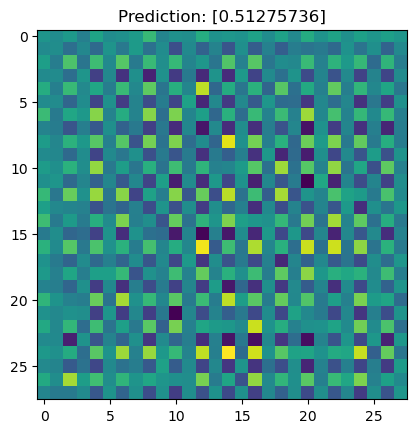

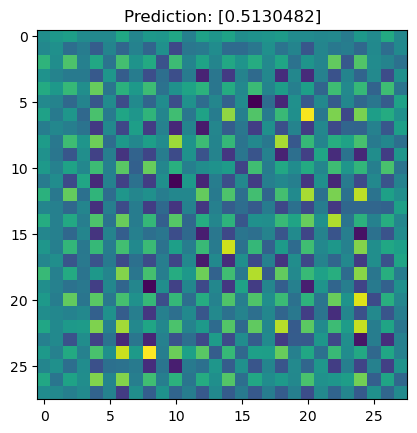

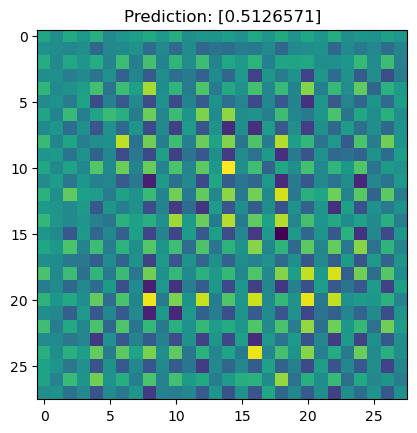

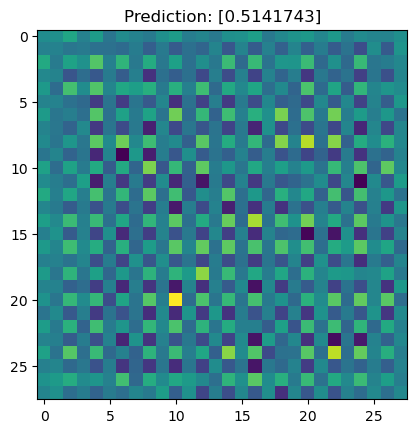

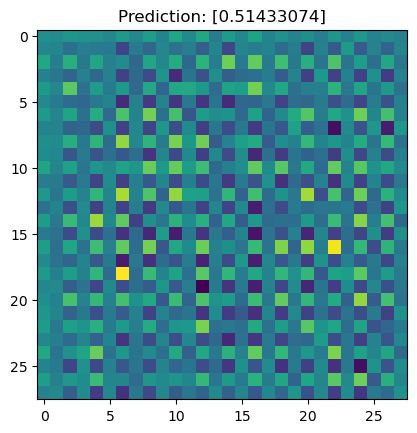

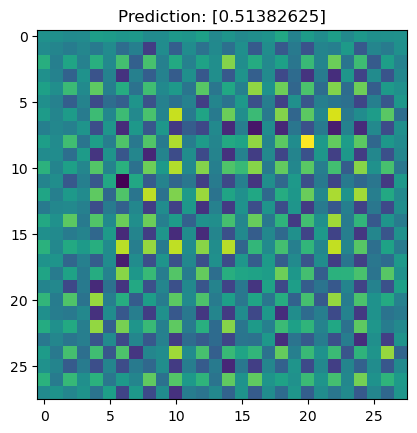

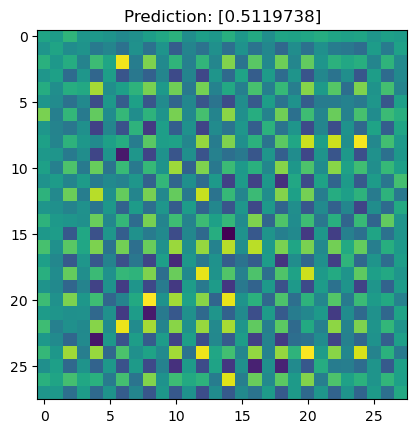

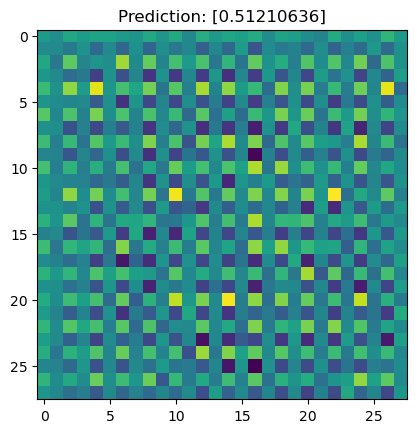

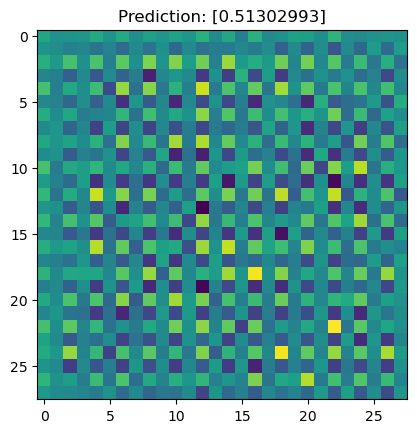

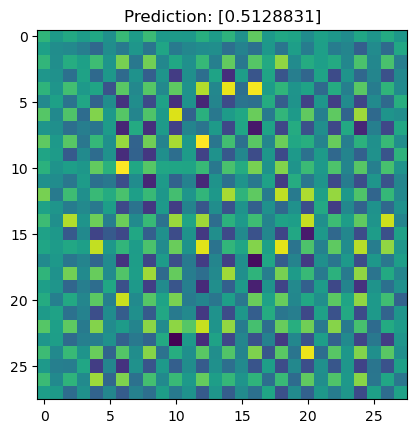

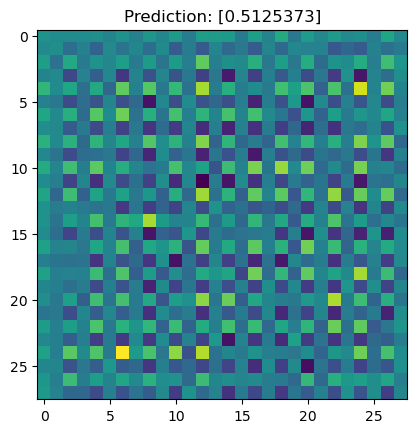

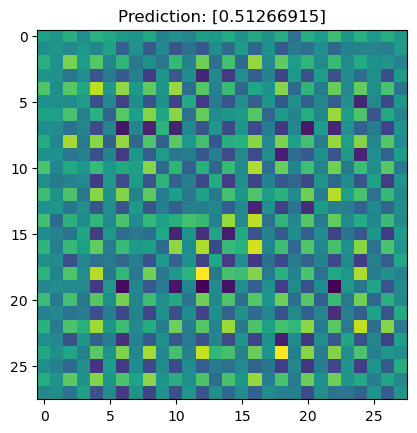

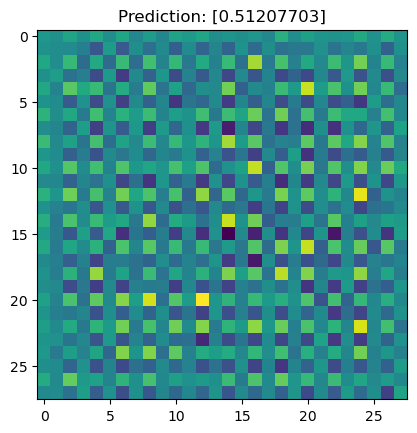

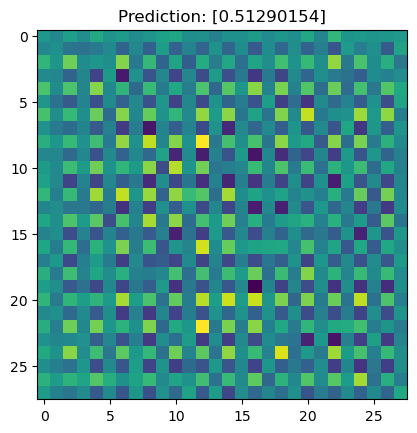

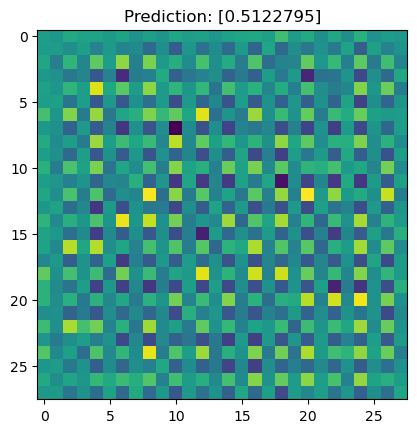

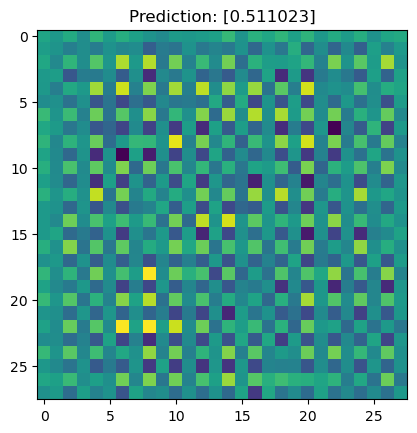

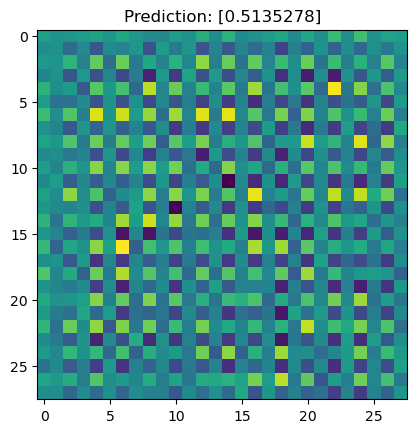

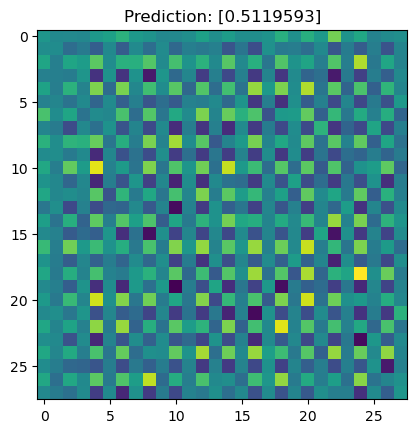

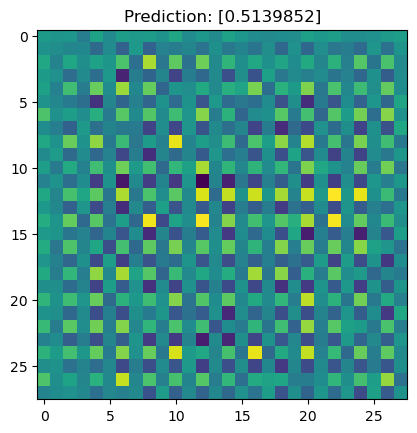

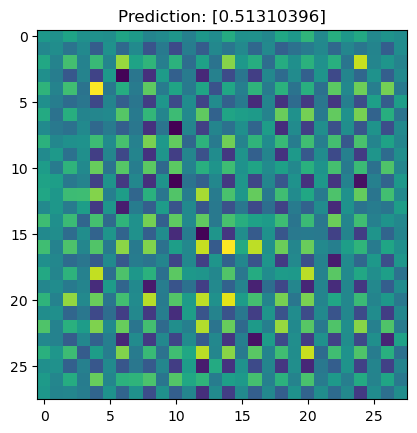

In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
train_images = images


# Normalize the images to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=3)


# Set the dimensions of the generator's input noise
latent_dim = 100

# Define the generator model
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*256, input_dim=latent_dim),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding='same', activation='tanh')
])

# Define the discriminator model
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Combine the generator and discriminator into a single model
gan = tf.keras.Sequential([generator, discriminator])

# Compile the GAN model
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# Define a function to generate fake images
def generate_images(generator_model, epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator_model.predict(noise)
    generated_images = generated_images * 0.5 + 0.5
    fig = plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_mnist_epoch{epoch}.png")

# Define the training loop
def train(epochs, batch_size=128, save_interval=50):
    # Calculate the number of batches per epoch
    batch_count = train_images.shape[0] // batch_size

    # Train the model for the specified number of epochs
    for epoch in range(epochs):
        for batch in range(batch_count):
            # Get a batch of real images
            real_images = train_images[np.random.randint(0, train_images.shape[0], size=batch_size)].squeeze(axis=-1)
            print("r",real_images.shape)

            # Generate a batch of fake images
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            fake_images = generator.predict(noise)
            print("f",fake_images.shape)
            
            # Concatenate the real and fake images into a single batch
            x = np.concatenate((real_images, fake_images))

            # Create the labels for the discriminator
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0

            # Train the discriminator on this batch of images
            print("x-shape",x.shape)
            print("y-shape",y.shape)
            d_loss, d_acc = discriminator.train_on_batch(x, y)

            # Train the generator by fooling the discriminator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y = np.ones([batch_size, 1])
            g_loss = gan.train_on_batch(noise, y)
            # Print the progress
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch}/{batch_count}, D_loss: {d_loss:.3f}, D_acc: {d_acc*100:.2f}%, G_loss: {g_loss:.3f}")

        # Save the generated images every save_interval epochs
        if epoch % save_interval == 0:
            generate_images(generator, epoch)

    # Save the final generator model
    generator.save("mnist_gan_generator.h5")
    
def predicttest(test_images):
    
    # Get a batch of real images
    real_images = test_images[:100]

    # Generate a batch of fake images
    noise = np.random.normal(0, 1, size=[100, 100])
    generated_images = generator.predict(noise)

    # Use the discriminator to predict whether each image is real or fake
    real_labels = np.ones((100, 1))
    fake_labels = np.zeros((100, 1))
    discriminator_labels = np.vstack([real_labels, fake_labels])
    images=np.vstack([real_images, generated_images])
    discriminator_predictions = discriminator.predict(images)

    # Evaluate the discriminator's performance
    accuracy = np.mean((discriminator_predictions > 0.5) == discriminator_labels)
    print(f"Discriminator accuracy: {accuracy}")
    
    for i in range(len(images)):
        plt.imshow(images[i])
        plt.title("Prediction: {}".format(discriminator_predictions[i]))
        plt.show()




trainmodel= train(1, batch_size=30, save_interval=50)
# Load the MNIST dataset
test_images = images
# Normalize the test images to [-1, 1]
test_images = (test_images.astype('float32') - 127.5) / 127.5
#test_images = np.expand_dims(test_images, axis=3)

predicttest(test_images)

In [19]:
from keras.models import load_model
accu=[]
model = load_model('mnist_gan_generator.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
def white_box_attack(x_test, y_test, generator, discriminator, epsilon=0.1):
    x_adv = np.zeros_like(x_test)

    for i in range(len(x_test)):
        # Generate adversarial example
        print("test no",i,"/",len(x_test))
        x = x_test[i]
        y_true = y_test[i]
        y_test_i = np.expand_dims(y_test[i], axis=0)
        noise = np.random.normal(0, 1, (1, 100))
        generated_image = generator.predict(noise)
        d_loss, d_acc = discriminator.evaluate(x.reshape(1, 28, 28, 1))
        g_loss, g_acc = discriminator.evaluate(generated_image)
        if g_acc > d_acc:
            # If the generator is more accurate than the discriminator, add perturbation
            print("generator is more accurate than discriminator")
            perturbation = np.sign(generator.gradient(noise, y_true)) * epsilon
            x_adv[i] = np.clip(generated_image + perturbation, 0, 1)
           
        else:
            
            x_adv[i] = generated_image
            x_adv_i = np.expand_dims(x_adv[i], axis=0)
            x_adv_i  =x_adv_i.reshape((1, 28*28))
            x_adv_i = x_adv_i[:,:100]
            print("x_adv[i]",x_adv_i.shape)
            #y_test_i = np.squeeze(np.reshape(y_test, (-1, 28, 28, 1)))
            print("y_test[i]",y_test[i].shape)
            
            #y_test_i = np.squeeze(y_test[i], axis=0)
            #y_test_i = np.reshape(y_test_i, (-1, 28, 28, 1))
            
      
        loss, acc = model.evaluate(x_adv_i, y_test_i)
        print('Target model accuracy on the adversarial examples:', acc)
        accu.append(acc)
        print(acc)
         

    return accu


x_test = images
y_test = images

accur=white_box_attack(x_test, y_test, generator, discriminator, epsilon=0.1)




test no 0 / 128
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 236ms/step - loss: 7.2094e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 1 / 128
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 19ms/step - loss: 7.5436e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 2 / 128
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 18ms/step - loss: 7.5312e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 3 / 128
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - a

1/1 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 29ms/step - loss: 7.6099e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 19 / 128
1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 47ms/step - loss: 7.8586e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 20 / 128
1/1 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 63ms/step - loss: 8.2741e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 21 / 128
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 0.000

1/1 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 31ms/step - loss: 7.7527e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 37 / 128
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 23ms/step - loss: 8.6222e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 38 / 128
1/1 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 31ms/step - loss: 7.2002e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 39 / 128
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.000

1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 31ms/step - loss: 7.9871e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 55 / 128
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 16ms/step - loss: 8.4166e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 56 / 128
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 47ms/step - loss: 8.0510e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 57 / 128
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.000

1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 16ms/step - loss: 7.8472e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 73 / 128
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 37ms/step - loss: 7.7139e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 74 / 128
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 31ms/step - loss: 8.3634e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 75 / 128
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 0.000

x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 31ms/step - loss: 8.1992e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 91 / 128
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 16ms/step - loss: 7.8054e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 92 / 128
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 16ms/step - loss: 8.1471e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 93 / 128
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 52ms/s

1/1 [==============================] - 0s 31ms/step - loss: 8.3001e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 109 / 128
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 23ms/step - loss: 7.9069e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 110 / 128
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 47ms/step - loss: 7.7736e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 111 / 128
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 16ms/step - loss: 7.9433e-08 - accuracy: 0.

1/1 [==============================] - 0s 10ms/step - loss: 7.7993e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0
test no 127 / 128
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
x_adv[i] (1, 100)
y_test[i] (28, 28, 1)
1/1 [==============================] - 0s 32ms/step - loss: 7.2967e-08 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
0.0


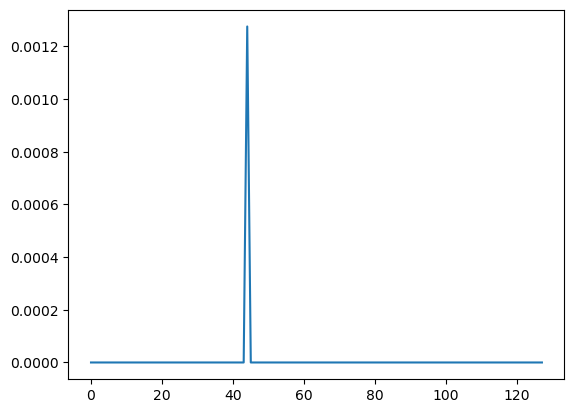

In [20]:
import matplotlib.pyplot as plt

x= list(range(0,len(accur)))

plt.plot(x, accur)
plt.show()

In [21]:
import numpy as np
from keras.datasets import mnist
from keras.models import load_model
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf

# Load the MNIST dataset
x_test = images
y_test= images
#
accu=[]
# Preprocess the data
x_test = x_test[:784].astype('float32') / 255.
y_test = x_test[:784].astype('float32') / 255.
print("shape", y_test.shape)
# Load the target model (black box)
model = load_model('mnist_gan_generator.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Define the black box attack function
def black_box_attack(x_test, y_test, model):
    epsilon = 0.1  # Perturbation size
    #x_adv = np.zeros_like(28,28)
    x_adv = np.empty((10000, 1, 100))



    print("xtest shape",x_test.shape)
    print("x_adv shape",x_adv.shape)

    for i in range(len(x_test)):
        print("x_test no:",i,"/",len(x_test))
        # Generate adversarial example
        x = x_test[i]
        y_true = y_test[i]
        noise = np.random.normal(0, 1, (1, 100))
        
        print("noise shape",noise.shape)
        generated_image = model.predict(noise)
        print("generated_image shape",generated_image.shape)
        generated_image = generated_image.reshape((1, 28*28))
        generated_image = generated_image[:,:100]
        print("updated generated_image shape",generated_image.shape)
        #generated_image = generated_image.reshape((28, 28, 1)) # reshape to match the input shape of the target model
        generated_image = np.clip(generated_image, 0, 1) # clip the values to [0, 1]
        test=model.predict(generated_image)
        y_pred_label = np.argmax(test)
        y_test = np.reshape(y_test[:784], (-1, 28, 28, 1))
        print("xyz",y_test[i][np.newaxis, ...].shape)
        if y_pred_label == np.argmax(y_true):
            # If the prediction is correct, add perturbation
            print("prediction is correct")
            #perturbation = np.sign(model.gradient(np.array([generated_image]), np.array([y_true]))) * epsilon
            #x_adv[i] = np.clip(generated_image + perturbation, 0, 1)
            
            with tf.GradientTape() as tape:
                generated_image_tensor = tf.convert_to_tensor(generated_image)
                tape.watch(generated_image_tensor)
                print(generated_image_tensor.shape)
                #generated_image_tensor= generated_image_tensor.numpy().reshape((1, 28*28))
                #generated_image_tensor =tf.convert_to_tensor(generated_image_tensor[:,:100])
                tape.watch(generated_image_tensor)
                y_pred = model(generated_image_tensor)
                y_true = tf.expand_dims(y_true, axis=0) # add an extra dimension to match the shape of y_pred
                #y_true=tf.expand_dims(y_true, axis=-1)
                loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
                #print("loss",loss)
                #print("gradient", tf.convert_to_tensor(generated_image_tensor))
            gradients = tape.gradient(loss, generated_image_tensor)
            #print("gradient", gradients)
            perturbation = 0.01 * tf.sign(gradients)
            generated_image = generated_image + perturbation.numpy()
            x_adv[i]= generated_image
            
            
        else:
            print("prediction is not correct")
            print("generated_image shape",generated_image.shape)
            print("x_adv shape",x_adv.shape)
            x_adv[i] = generated_image
            print("abc",x_adv[i].shape)
            
        loss, acc = model.evaluate(x_adv[i], y_test[i][np.newaxis, ...])
        print('Target model accuracy on the adversarial examples:', acc)
        accu.append(acc)
            
    return accu

#print("xtestshape",x_test.shape)
#print("y_test",y_test.shape)
# Generate the adversarial examples
accur= black_box_attack(x_test, y_test, model)

shape (128, 28, 28, 1)
xtest shape (128, 28, 28, 1)
x_adv shape (10000, 1, 100)
x_test no: 0 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 104ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 20ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 262ms/step - loss: 1.1087e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 1 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 27ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 17ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 31ms/step - loss: 1.1601e-12 - accuracy: 0.0000e+00
T

1/1 [==============================] - 0s 25ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 47ms/step - loss: 1.1366e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 17 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 27ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 32ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 15ms/step - loss: 1.2710e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 18 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 15ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [=====================

1/1 [==============================] - 0s 15ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 31ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 33ms/step - loss: 1.1621e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 34 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 31ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 25ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 32ms/step - loss: 1.2807e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 35 / 128
noise shape (1, 100)
1/1 [=====================

Target model accuracy on the adversarial examples: 0.0
x_test no: 50 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 48ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 35ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 27ms/step - loss: 1.2511e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 51 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 31ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 21ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 35ms/step - loss: 1.2394e-12 - accuracy: 0.0000e+00
Target model accuracy on t

1/1 [==============================] - 0s 36ms/step - loss: 1.0580e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 67 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 34ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 31ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 49ms/step - loss: 1.2241e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 68 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 12ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 28ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [=====================

1/1 [==============================] - 0s 16ms/step - loss: 1.2301e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 84 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 30ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 18ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 21ms/step - loss: 1.2765e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 85 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 31ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 33ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [=====================

1/1 [==============================] - 0s 47ms/step - loss: 1.1444e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 101 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 31ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 31ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 31ms/step - loss: 1.2296e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 102 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 24ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 16ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [===================

1/1 [==============================] - 0s 16ms/step - loss: 1.1540e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 118 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 16ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 16ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [==============================] - 0s 31ms/step - loss: 1.2371e-12 - accuracy: 0.0000e+00
Target model accuracy on the adversarial examples: 0.0
x_test no: 119 / 128
noise shape (1, 100)
1/1 [==============================] - 0s 16ms/step
generated_image shape (1, 28, 28, 1)
updated generated_image shape (1, 100)
1/1 [==============================] - 0s 16ms/step
xyz (1, 28, 28, 1)
prediction is not correct
generated_image shape (1, 100)
x_adv shape (10000, 1, 100)
abc (1, 100)
1/1 [===================

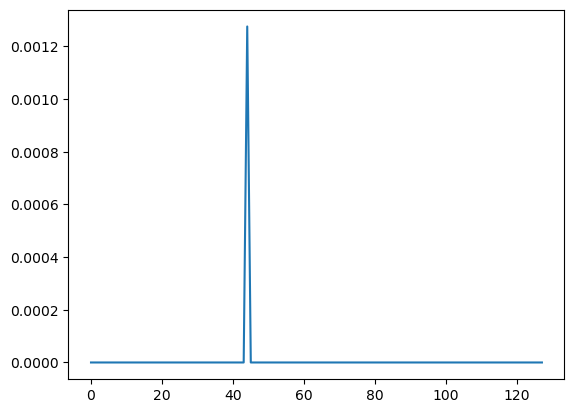

In [22]:
import matplotlib.pyplot as plt

x= list(range(0,len(accur)))

plt.plot(x, accur)
plt.show()